In [427]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve, confusion_matrix
from IPython.display import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from math import sqrt
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.patches as patches
import os
import re
import time
import random
import colorama
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [428]:
t0=time.time()
bold='\033[1m{}\033[0m'
bold=bold.format

underline="\u0332".join


# Part 1: modifing and analyizing of the data

#### on that part we start to analize the Data and modify it for terms which are more comfortable for working 

In [429]:
def clean_data(df:pd.DataFrame):
    #variables define
    months = {"Jan":1, "Feb":2, "Mar":3,"Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
    num_rows = df.shape[0]
    user_type = {"Returning_Visitor":2.00, "New_Visitor":1.00, "Other":0.00}
    pattern = r'[^0-9.]+'

    #replace NAN at duration cell with 0 wherever num of pages == 0
    df["info_page_duration"][df.num_of_info_pages==0]=0
    df["admin_page_duration"][df.num_of_admin_pages==0]=0
    df["product_page_duration"][df.num_of_product_pages==0]=0

    # convert the weekend feature to numeric values.
    df.Weekend[df.Weekend==False]=0.00
    df.Weekend[df.Weekend==True]=1.00
    df.Weekend=df.Weekend.astype(float)
    
    
    for i in user_type:
        df["user_type"][df["user_type"]==i]=user_type[i]
    df["user_type"]=df["user_type"].astype(float)  


    for i in range(num_rows):
        #convertion to float
        if(isinstance(df.info_page_duration[i], str)):
            df.info_page_duration[i] = float(re.sub(pattern, '', df.info_page_duration[i]))
        
        if(isinstance(df.product_page_duration[i], str)):    
            df.product_page_duration[i] = float(re.sub(pattern, '', df.product_page_duration[i]))
            
        
        
        #changing the month
        df.Month[i] = months.get(df.Month[i])

        # modify the times
        prod = df.product_page_duration[i]
        info = df.info_page_duration[i]
        admin = df.admin_page_duration[i]
        tot = df.total_duration[i]
        
        #the duration times fixing
        if(pd.isna(tot)):
            if(pd.isna(prod) or pd.isna(info) or pd.isna(admin)):
                continue
            df.total_duration[i] = prod + info + admin
        elif(pd.isna(prod)):
            if(pd.isna(info) or pd.isna(admin)):
                continue
            df.product_page_duration[i] = tot - info - admin
        elif(pd.isna(info)):
            if(pd.isna(admin)):
                continue
            df.info_page_duration[i] = tot - prod - admin
        elif(pd.isna(admin)):
            df.admin_page_duration[i] = tot - prod - info
    # ----------------------------------------------------------------

    #end of loop
    
    #convert columns into lowercase
    df.columns = [col.lower() for col in df]


    #convert page durations into float type
    df[['product_page_duration', 'info_page_duration']]=df[['product_page_duration', 'info_page_duration']].astype(float)
    
    # change the c column into logging
    df.rename(columns = {'c':"logging"}, inplace = True)
    
    #convert months into float mode
    df.month=df.month.astype(float)
    return df

In [430]:
#CSV reading
train_data = pd.read_csv("train.csv",index_col=0)
test_data = pd.read_csv("test.csv",index_col=0)

 
#first cleaning and modifing of the data
X_train=clean_data(train_data)
X_test=clean_data(test_data)

### so lets explain what we have done until now:

- we have converted some of the non numeric values into numeric values(for example the features **month** and **user type**
- we have completed the missing values as much as possible in te time duration values. 
  for example: if we had data on all specific time durations(admin,product, info)
  but NAN value at total duration we could infer after view the data that 

## NaN rate filtering:

Here we check the **NaN** rate for each feature in order to filter fetures which we dont have enough informaton about them or in other words, high NaN rate

In [431]:
def plot_NaN_features(df:pd.DataFrame,u,specific_colname):
    lst = []
    for i in df.columns:
        num = df[i][df[i].isna()].shape[0]
        lst.append(100*num/df.shape[0])
        #print(f'precentage of NaN in feature "{i}" is : {100*num/train_data.shape[0]}%')

    di = pd.DataFrame({"colnames": df.columns, "percentage": lst})
    di = di.sort_values(by="percentage", ascending=False)
    plt.figure(figsize=(20, 6))
    plt.grid(axis='y')

    #mark a specific column if required
    colora=[]
    for i in di.colnames:
        if specific_colname==None:
            colora.append("blue")
            continue
        if i in specific_colname:
            colora.append("red")
        else:
            colora.append("blue") 

    #plot the diagram
    
    plt.bar(di.colnames, di.percentage,color=colora)
    plt.xticks(rotation=90, fontsize=14)
    plt.ylabel(" NAN percantage %", fontsize=14)
    le=u.split(" ")
    title="NaN rate per feature: "

    #present the rate
    for i,j in enumerate(sorted(lst,reverse=True)):
            plt.text(i-0.4,j+0.01*max(lst),str(round(j,2))+"%",fontsize=14)   
    #design the title
    for i in le:
        title+=r"$\bf{" + i+ "}$"+" "
    
    plt.title(title, fontsize=14)
    plt.show()
    return di

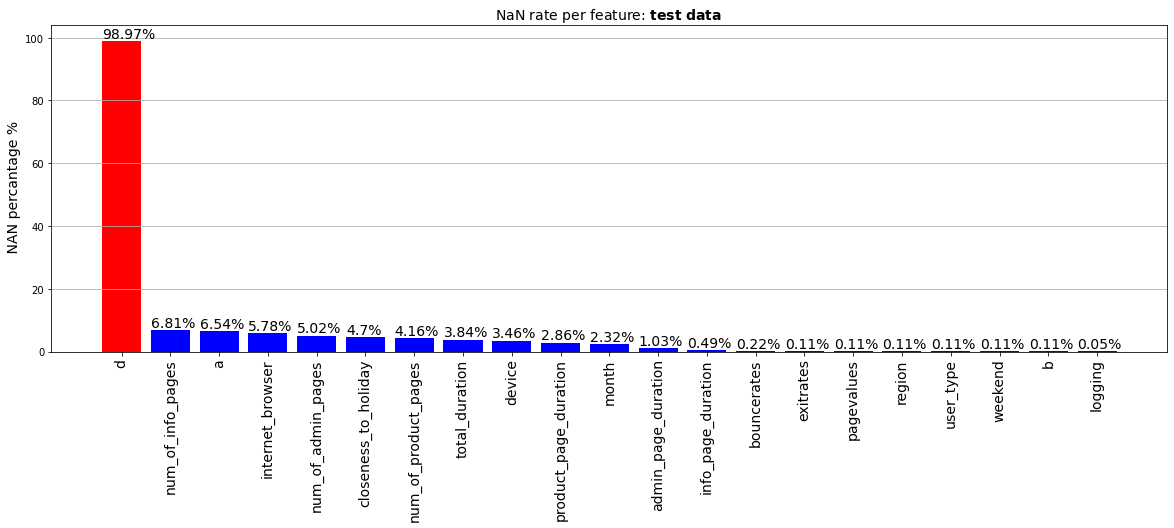

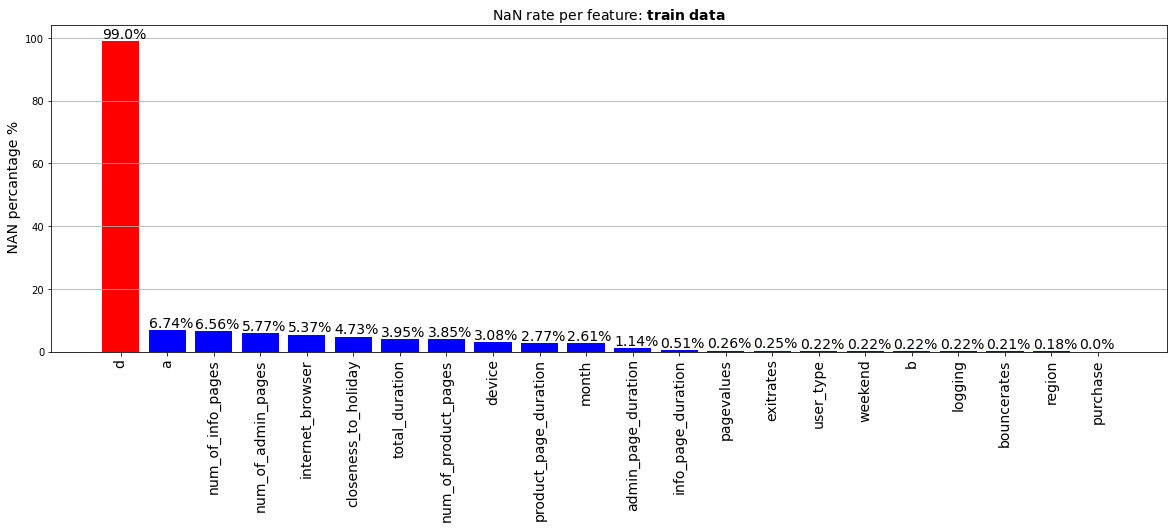

In [432]:

test_NA=plot_NaN_features(X_test,"test data",specific_colname=['d'])
train_NA=plot_NaN_features(X_train,"train data",specific_colname=['d'])

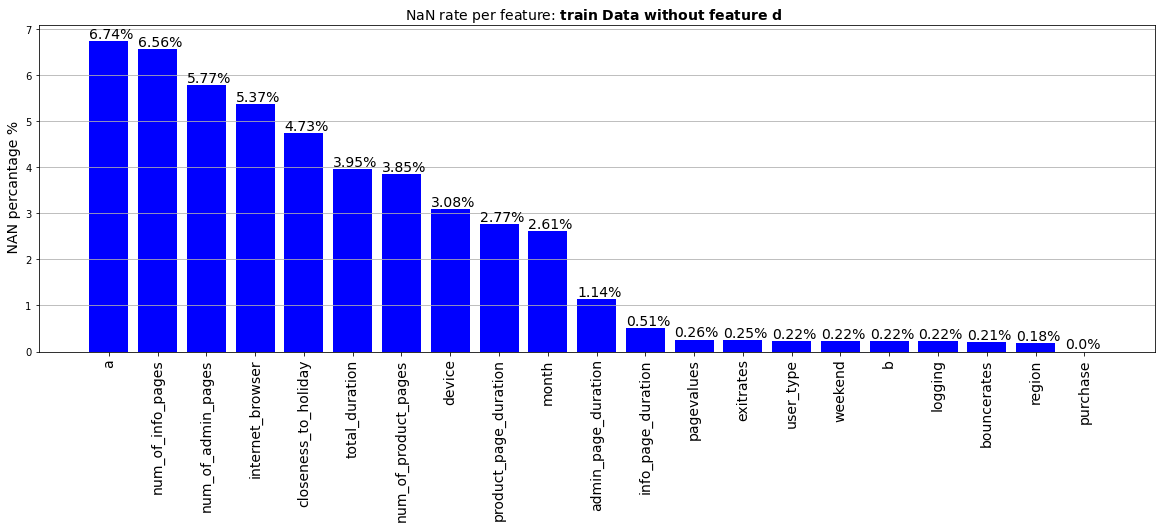

In [433]:
#NAN rate on train data if we remove "d"
t=X_train.drop("d",axis=1).copy()
t_NA=plot_NaN_features(t,'train Data without feature d ',specific_colname=[])

Here we get all numeric and non numeric columns

In [434]:
#numeric columns
numeric=X_train.select_dtypes(include=[np.number]).columns 


#non numeric columns
non_numeric=list(set(X_train.columns) - set(numeric))

non_numeric

['a', 'internet_browser', 'logging']

## ploting and check distribution of numeric features:

here we want to see how any variable been distributed.(normal,exponential,randomal etc').
we will start with numeric columns and afterwards we will continue to non numeric columns

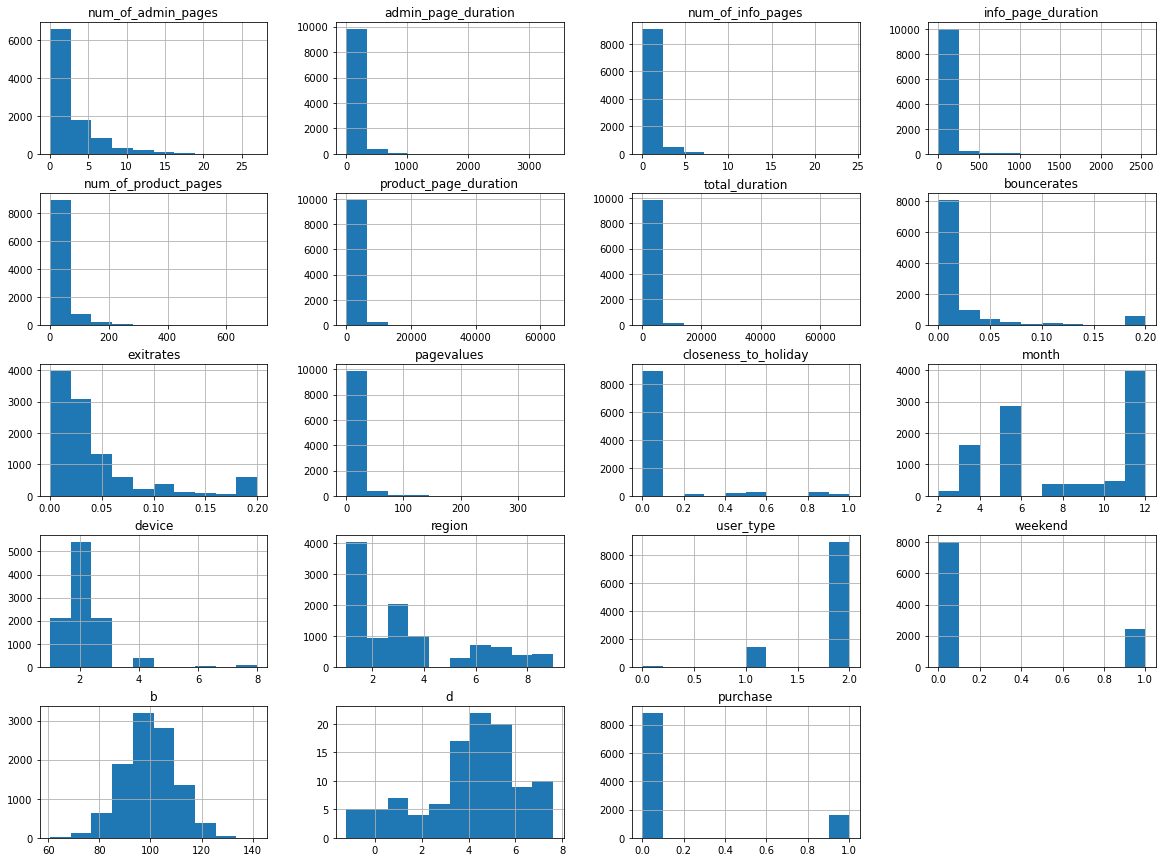

In [435]:

ax=X_train.hist(figsize=(20,15))
plt.show()

Here we can see that the majority of features are concentrated according very specific values range. for example the feature **"closennes to holiday"** we can see that vast majority of values are between 0 to 0.2. same as many other features.

At that heatmap we will check the correlation among all features.

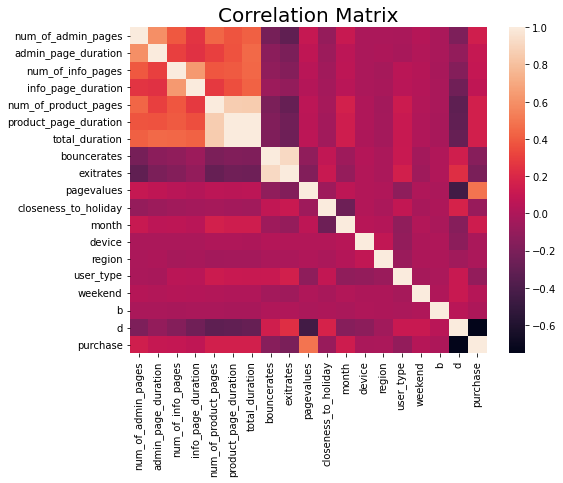

In [436]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("correlation matrix".title(),fontsize=20)
sns.heatmap(X_train.corr())

plt.show()


### ***explanation***:
 we saw there is very high negative correlation between d and purchase. 
and due to that and due to the reason that d has almost 99% nan-rate we will remove that column form our model.

#### finding highest correlation rates(we put a minimum requirment of abs (0.5))

In [437]:
def strong_correlation(df:pd.DataFrame):    
    a=df.corr().copy()
    correlation=[]
    for i in a:
        for j in a:
            
            if ([j,i,round(a[i][j],3)] in correlation):
                continue
            if (j!=i) and (abs(a[i][j])>=0.5):
                correlation.append([i,j,round(a[i][j],3)])
                
    print(bold("Strongest correlations in our train Data:"))    
    for i in correlation:
        print("Correlation between",colorama.Fore.GREEN+(bold('"'+i[0]+'"')),"and", colorama.Fore.GREEN+bold('"'+i[1]+'"'), "is:",colorama.Fore.RED+bold(i[2]))

In [438]:
strong_correlation(X_train)

Strongest correlations in our train Data:
Correlation between "num_of_admin_pages" and "admin_page_duration" is: 0.594
Correlation between "num_of_info_pages" and "info_page_duration" is: 0.631
Correlation between "num_of_product_pages" and "product_page_duration" is: 0.86
Correlation between "num_of_product_pages" and "total_duration" is: 0.85
Correlation between "product_page_duration" and "total_duration" is: 0.994
Correlation between "bouncerates" and "exitrates" is: 0.912
Correlation between "d" and "purchase" is: -0.753


### conclustions:

- we will remove "d" due to very high nan rate
- we should complete a lot of data and convert part of it to numeric values.


 # part 2. initial removing of outliers and unnecesarry columns

 ##### we would like to remove from the DATA  rows with many NAN rates and columns without much information. in addition we want to filter columns with high correlation rate and high NAN rate.

the way of working at this part:

 1. it will be routine method of completing Data, and removing outliers and then completion of additional Data and removal of additional outliers.

 2. after the first part we will keep removing outliers and at the same breath we will start to remove colums or build new features(depands on the feature)

#####  Function for removal of features and rows in a responsible way

In [439]:
#remove columns(features)
def remove_columns(df:pd.DataFrame,features_to_remove_list):
    #case for feature list
    lst=[]
    for i in features_to_remove_list:
        if i in df.columns:
            lst.append(i)

    #case for single feature        
    if type(features_to_remove_list)==str:
        if features_to_remove_list in df.columns:
            lst.append (features_to_remove_list)  

    if lst==[]:
        print("nothing been removed")         
    return df.drop(lst,axis=1)


#remove rows    
def remove_rows(df:pd.DataFrame,indexes_to_remove):
    
    #case for feature list
    lst=[]
    for i in indexes_to_remove:
        if i in df.index:
            lst.append(i) 

    #case for single feature
    if type(indexes_to_remove)==str:
        if indexes_to_remove in df.columns:
            lst.append (indexes_to_remove) 

    if lst==[]:
        print("nothing been removed. maybe because ")        
    return df.drop(lst,axis=0)              

1. remove feature "d"

In [440]:
X_train=remove_columns(X_train,features_to_remove_list=["d"])
X_test=remove_columns(X_test,features_to_remove_list=["d"])

### 2. remove high nan rate rows

In [441]:
#check the train nan-rate
X_nan=X_train.isna().sum(axis=1).sort_values(ascending=False)
nan_max=2
X_nan=X_nan[X_nan<=nan_max]
print (f"for train data when the max {('NaN-values')} per row is: {nan_max} , we have {X_nan.shape[0]}\
 values which constitues {colorama.Fore.RED+(bold(str(round(100*X_nan.shape[0]/X_train.shape[0],2))+' %'))}\
       {colorama.Fore.RESET+'of total train Data rows'}.\n")



for train data when the max NaN-values per row is: 2 , we have 10240 values which constitues 97.72 %       of total train Data rows.



#### we can see this kind of filter(remove all rows above 2 nan-values in it) helps us to reduce the nan-rate without reducing so much the samples(num of rows)

#### remove those rows(with more then 2 nan values)

In [442]:
#X_train remove  some outliers
X_nan=X_train.isna().sum(axis=1).sort_values(ascending=False)
X_nan=X_nan[X_nan>2]
X_train=remove_rows(X_train,X_nan.index.sort_values().tolist())




##### so here at the block above we have removed all outliers with more then,<br> 2 NAN values. we have removed them, because we do not want rows to be with high amount of completed values rate. it may reduce the quality of our performance, to fit a model according to values, which we do not have a gurantee they are the real values.

lets plot after the first 2 filtering

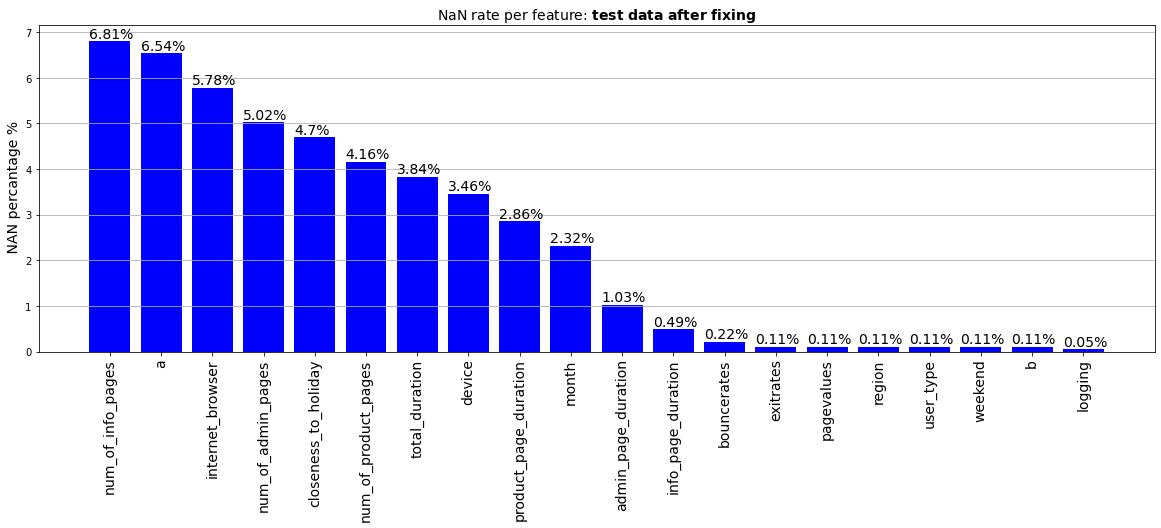

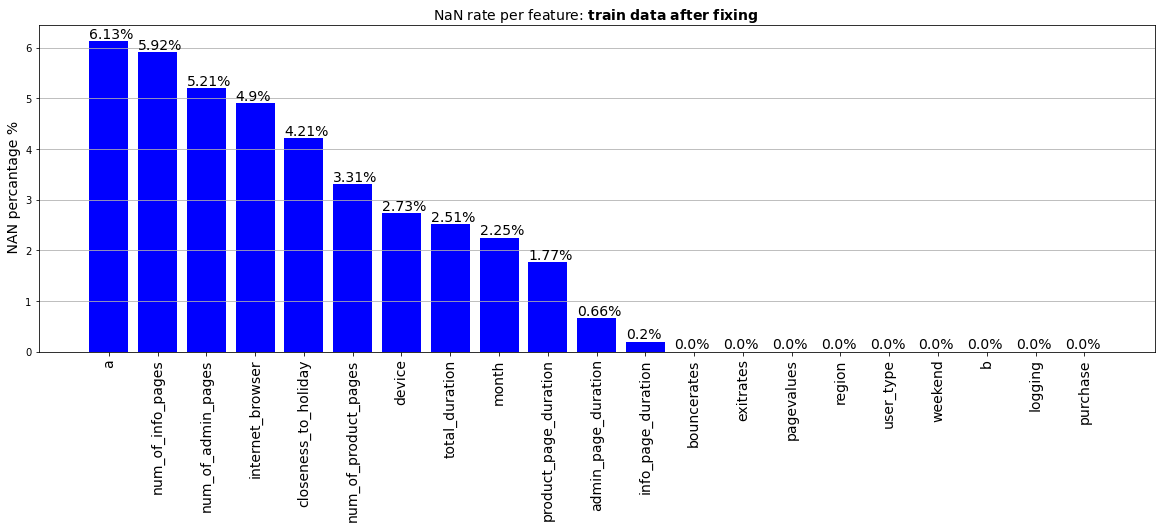

In [443]:
#plot test nan rate
test_NA=plot_NaN_features(X_test,"test data after fixing",specific_colname=None)

#plot train NAN rate
t_NA=plot_NaN_features(X_train,"train data after fixing",specific_colname=None)

We can definitly see that NAN rate became to 0 in many features

## completion of missing values

- for each variable which described and distributes differently we will handle at differen way
- we will distribute the features to numeric and non numeric.
- for the non numeric after completion and filtering we will convert to numeric

### for categorial features: 
on one model we will convert them into numeric values and make sure they are close to each other(for example the logging feature which we will see on next cells)
<br>
one the PCA matrix we will scale all data before training the PCA.(even the  categorial features after converted)

we will remove outliers (for example some categories which there are very low quantity of samples about them)



## time filling
 we will fill the durations and pages numbers simultanusly because they are associated and we will devied it into 3 steps:<br>
 1. set 1 is for cases which duration is 0 and pagetye is NAN

 2. set 2 is for cases which num of pages is NAN but the duration bigger than 0
 
 3. set 3 is for cases which num of pages higher then 0 and duration is NAN<br><br> 
- each of those cases demands different type of completion.
- when variable is categorial we will complete at the **probability** method.
- when the feature is not categorial, like durations, we will complete at "median" method



 

### probability method (for categorial features)
as we probably know when we complete data we cant just randomaly complete it. it may cause many errors at the model later.
#### therfore we will work at the probability mountain layers method

1. we will check all columns with non-missing values and check the statistics. what is the apearance rate of each category.

2. we will calculate the probability and round it. we will put a thershold that under 0.5% of all samples we wont complete with that category.

3. we will do rounds of 100 fillings each. on each round we will distribute the categories according of their apearance rate in the filled Data. 

**for example:**
category 1,2,3 = 60%, 20% ,20%<br>
so one 100 filling round,
<br>60 values will get 1<br>20 will get 2<br> and 20 will get 3

distribution wont be same every time, and if we will run the algorithem over and over again, same rows will get same values.

In [444]:
def create_apeare(df:pd.DataFrame):
    '''
    this function checks the probability that
    from all rows that page_type is not NAN and duration is 0
    a specific amount of pages is the real amount
    and creats a rounded probability list according to indexes
    '''

    page_name=df.columns[0]
    col_time=df.columns[1]
    d=df[page_name][ (df[col_time]==0) &(df[page_name].notna())].value_counts().sort_index()
    apeare=[0 for i in range (int(d.index.max()+1))]
    for i,j in enumerate(d):
        apeare[int(d.index[i])]=j

    # build a probability list. from 100 samples with 0.0 duration time 
    sum_appear=sum(apeare) 
    apeare_rate=[0 for i in range(len(apeare))]  
    for i,j in enumerate(apeare):
        apeare_rate[i]=round(apeare[i]*100/sum_appear)    
    return apeare_rate

#### time filling method which estimates the values should be places in the NAN cells of pages and durations

In [445]:

def time_filling(df:pd.DataFrame,di:pd.DataFrame):  
 
    df=df.copy()
    pages=['num_of_admin_pages','num_of_info_pages','num_of_product_pages']
    times=[]
    for i in df.columns:
        if "duration" in i:
            times.append(i)
    
    for index,page_name in enumerate(pages):
        #set
        col_time=times[index] #our duration which is connected to the type of pages.

        

        #-----------set 1---------------- 

        # set 1 is for cases which duration is 0 and pagetye is NAN
         
         
          
        apeare_rate=create_apeare(X_train[[page_name,col_time]])
        apeare_rate_copy=np.array(apeare_rate.copy())
        
        
        for i,j in enumerate(df[ (df[col_time]<=0) &(df[page_name].isna())].index):
            #return df.loc[j][page_name]

            index_ls=np.where(apeare_rate_copy>0)[0]
                       

            chosen=random.choice(index_ls)
            apeare_rate_copy[chosen]-=1
            df[page_name][j]=chosen
            

            if max(apeare_rate_copy)==0:
                apeare_rate_copy=np.array(apeare_rate.copy())
        #-------end of set 1---------------





        #-----------set 2----------------
        #set 2 is for cases which num of pages is NAN but the duration bigger than 0!!
        
           
        w=di[ (di[col_time]>0) &(di[page_name].notna())].copy()
        w["avarage"]=w[col_time]/w[page_name]
        median=w.avarage.median()
        df[page_name][ (df[col_time]>0) &(df[page_name].isna())]=round(df[col_time][ (df[col_time]>0) &(df[page_name].isna())]/median)
        
        #-------end of set 2---------------
        
        


        #------------set 3-----------------
        # set 3 is for cases which num of pages higher then 0 and duration is NAN
        w=di[ (di[col_time].notna()) &(di[page_name]>0)].copy()
        w["avarage"]=w[col_time]/w[page_name]
        median=w["avarage"].median()
        
        df[col_time][ (df[col_time].isna()) &(df[page_name]>0)]=df[page_name][ (df[col_time].isna()) &(df[page_name]>0)]*median
        #-------end of set 3---------------

        
    return df    

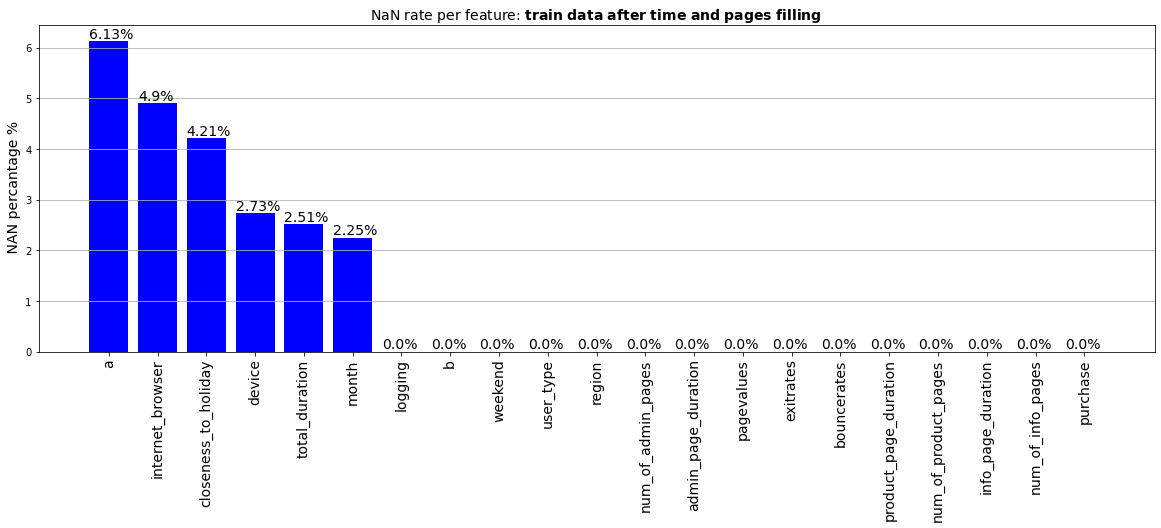

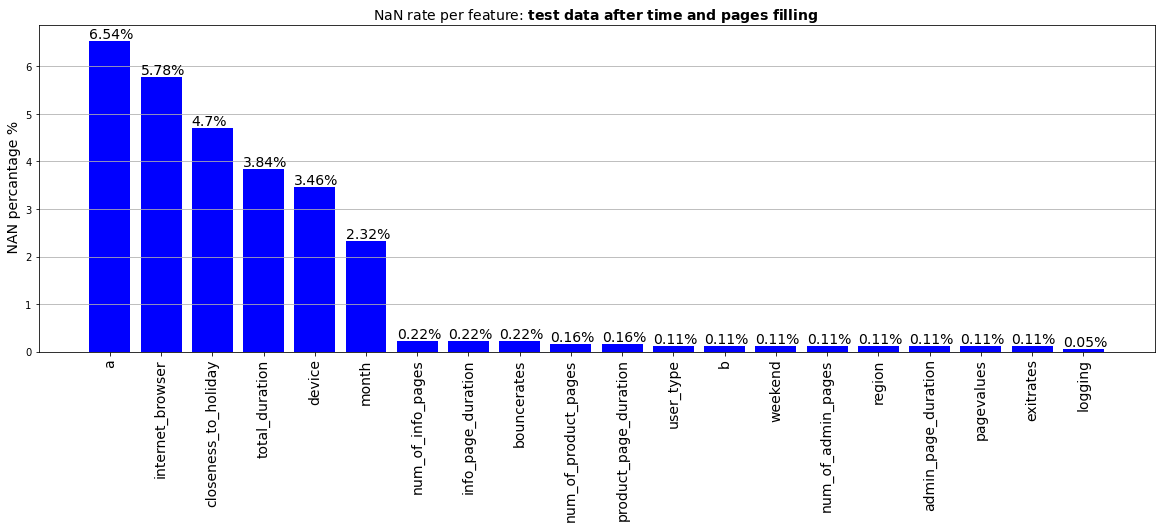

In [446]:

'''
we will define "q" as filled X_train, 
and "p" as filled X_test in, 
order to make adjustments and configuration easier
'''

q=time_filling(X_train,X_train)

p=time_filling(X_test,X_train)



train_NA=plot_NaN_features(q,"train data after time and pages filling",[])
test_NA=plot_NaN_features(p,"test data after time and pages filling",[])

## Special completion for test Data:

due to that we cant delete rows from test Data. we will make a special completion for the test data.

on train Data if  page type and duration type bot had NAN they have been classified as outliers and been removed.

here we cant so we will make special completion for test data.

#### important point:
in order to allow easier edition of data we will use q(X_train) and p(X_test) which are versions after time reduction. it will make the code easier for configuration



In [447]:
def filling_for_test1(df:pd.DataFrame,train:pd.DataFrame):
    df=df.copy()
    train=train.copy()

    #handling the times
    tlist=['info','admin','product']
    for i in tlist:
        timename=i+'_page_duration'
        pagename='num_of_'+i+"_pages"

        df[timename][df[timename].isna()]=train[timename][train[timename].notna()].median() 

    # becaue here we have on average 2 rows to complete no need to do statistical calculations. therfore we will just complete by majority of examples.
    df.bouncerates[df.bouncerates.isna()]=0.0
    df.exitrates[df.exitrates.isna()]=0.2
    df.pagevalues[df.pagevalues.isna()]=0.0
    df.region[df.region.isna()]=1.0
    df.user_type[df.user_type.isna()]=2.0
    df.weekend[df.weekend.isna()]=0.0
    df.logging[df.logging.isna()]='log200'
    df.b[df.b.isna()]=train.b[train.b.notna()].mean()
    #bouncerates, logging, reagon, pagevalues, exitrates,weekend,b,usertype
        
    return df

lets implement

In [448]:
p=filling_for_test1(p,X_train)
p=time_filling(p,X_train)


**ok** Done!! now lets reduce the "total_duration" NAN rate to 0 and lets measure again the nan rate

in that case we will sum all the duration types.

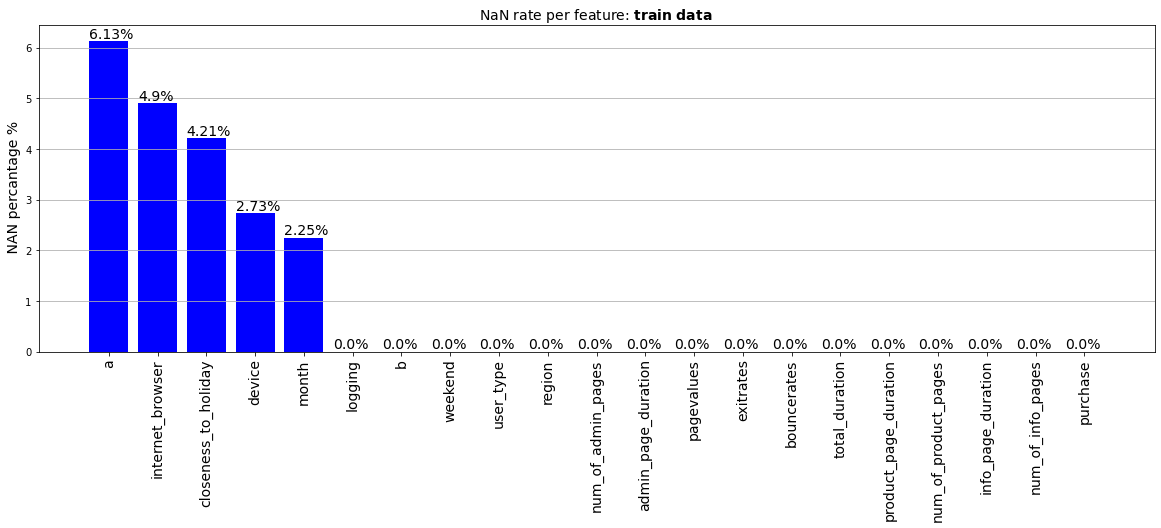

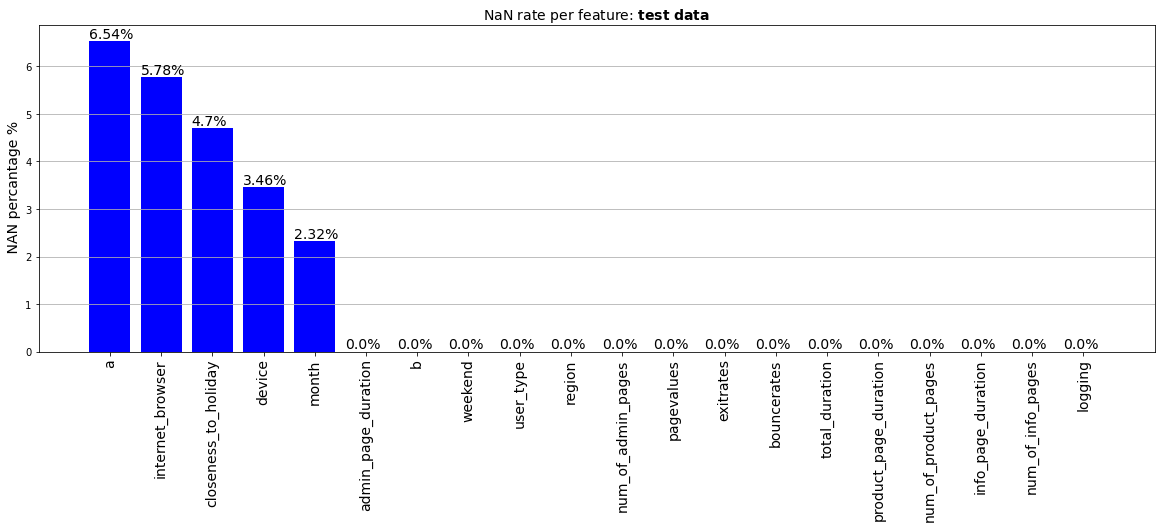

In [449]:
q.total_duration= q[["admin_page_duration","product_page_duration","info_page_duration"]].sum(axis=1)
p.total_duration= p[["admin_page_duration","product_page_duration","info_page_duration"]].sum(axis=1)


t=plot_NaN_features(q,"train data",None)
t1=plot_NaN_features(p,"test data",None)

now lets fucos at the last 2 numeric features: "month" and "device" 

both features are categorial ("month" was non numeric but been converted easily at the beggining)

we will do additional filtering of outliers. now after completion of part of the Data
we will classify as outliers, values with more then 1 NAN value

In [450]:
#filtering rows with more then 1 NAN values. train Data
a=q.isna().sum(axis=1).sort_values(ascending=False)

q[a<2].shape[0],train_data.shape[0]


(10097, 10479)

**train data**: original num of rows is 10479. and current (after filtering and completion is 10096)<br><br>

means we dont lose significant amount of data and we reduce measuring errors

In [451]:
q=remove_rows(q,q[a>=2].index.tolist())

last numeric part: completion of "month" and "device" and "closeness to holiday"

In [452]:
def month_complete(df:pd.DataFrame):
    df=df.copy()
    a=q.month.value_counts().sort_index().copy()
    lst=np.array([0 for i in range(13)])
    a=round(a*100/a.sum())
    for i in a.index:
        lst[int(i)]=a.loc[i]
    
    lst_copy=lst.copy() #anchor
    counter=0
    
    for i in df[df.month.isna()].index:
        
        months_above_0= np.where(lst>0)[0]

        if counter>=len(months_above_0):
            counter=0
        df.month[i]=months_above_0[counter]
        lst[months_above_0[counter]]-=1
        if not max(lst)>0:
            lst=lst_copy.copy()
        if lst[months_above_0[counter]]>0:    
            counter+=1   
    return df    


      
def closeness_to_holiday_fixing(df:pd.DataFrame):
    df=df.copy()
    a=q.closeness_to_holiday.value_counts().sort_index().copy()

    lst=np.array(round(100*a/a.sum()).tolist())
    lst_copy=lst.copy()
    counter=0
    
    for i in df[df.closeness_to_holiday.isna()].index:
        cth_above_0= np.where(lst>0)[0]
        if counter>=len(cth_above_0):
            counter=0
        df.closeness_to_holiday[i]=cth_above_0[counter]/5
        
        
        lst[cth_above_0[counter]]-=1
        if not max(lst)>0:
            lst=lst_copy.copy()
        if lst[cth_above_0[counter]]>0:    
            counter+=1
    return df
    



def device_fixing(df:pd.DataFrame):
    df=df.copy()
    a=q.device.value_counts().sort_index().copy()
    a=round(a*100/a.sum())
    a_copy=a.copy()
    counter=0
    d=0
    for i in df[df.device.isna()].index:
        w=a[a>0]
        indexes=w.index

        df.device[i]=indexes[counter]
        
        
        a[indexes[counter]]-=1
        counter+=1
        if counter>=w.shape[0]:
            counter=0
        if not a.max()>0:
            a=a_copy.copy()
    return df    
        

In [453]:
#complete the last features at the mountain method

q=month_complete(q)
p=month_complete(p)

q=closeness_to_holiday_fixing(q)
p=closeness_to_holiday_fixing(p)

q=device_fixing(q)
p=device_fixing(p)

#nan_rate=plot_NaN_features(device_fixing(q),"",None)

#### congrats!!
 we have done with the numeric columns. and lets go to the non numeric

In [454]:
#we finally ended with all changs and can merge train and test data to be the same with their own copies.

X_train=q
X_test=p


## non numeric columns



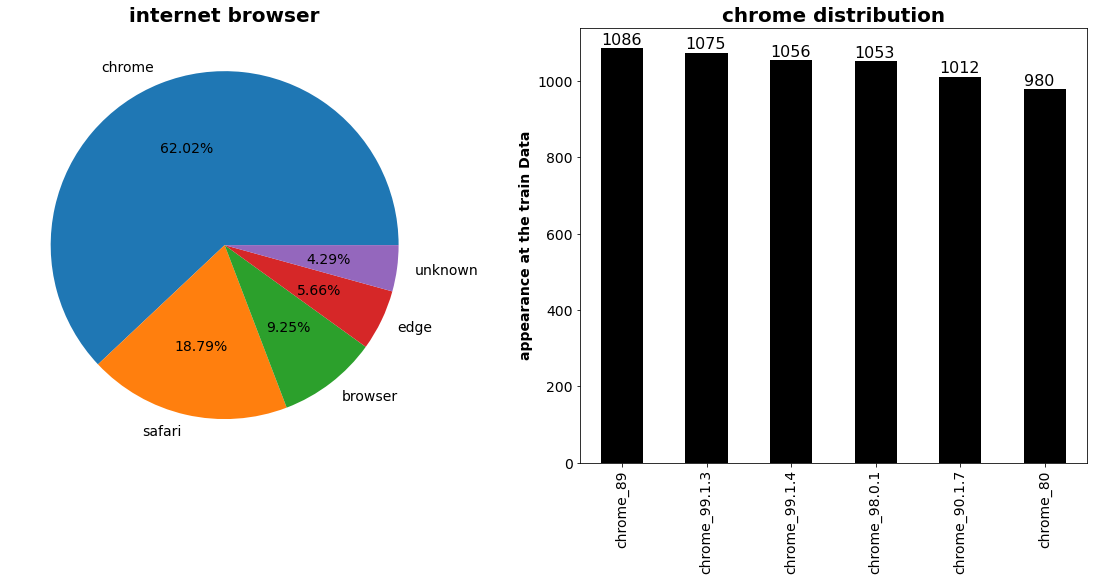

In [455]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
X_non_numeric=X_train[non_numeric].copy()

# plot the left diagram
browserlist=["safari","chrome","edge","browser"]
for i in browserlist:
    d=X_non_numeric.internet_browser.str.contains(i)        
    X_non_numeric.internet_browser[d==True]=i
X_non_numeric.internet_browser[X_non_numeric.internet_browser.isna()]="unknown"    
(100*X_non_numeric.internet_browser.value_counts()/X_train.shape[0]).plot(kind="pie",autopct='%1.2f%%',ax=axes[0],fontsize=14)


axes[0].set_title("internet browser",fontweight="bold",fontsize=20)
axes[0].set_ylabel("")




# plot the right diagram
X_non_numeric.internet_browser=X_train.internet_browser
d=X_non_numeric[X_non_numeric.internet_browser.str.contains("chrome")==True]
d_count=d.internet_browser.value_counts()
d_count.plot(kind="bar",ax=axes[1],fontsize=14,color="k")

axes[1].set_title("chrome distribution",fontweight="bold",fontsize=20)
axes[1].set_ylabel("appearance at the train Data",fontsize=14,fontweight="bold")
for i,j in enumerate(d_count):
    axes[1].text(i-0.25,j+10,str(j),fontsize=16)

plt.show()

we can see that the majority uses chrome version and the usage between different chrome version looks similar to Uniform distribution

Now lets test in more general way

In [456]:
def plot_non_numeric():  
    #set the plot  
    fig, axes = plt.subplots(3,1,figsize=(10,30))

    #set the indexes

    ''' means that the data that will appear at the chart is bigger then 0.5% of total sampels.
     of course that it may be changed in very simple way. just change the value in one of the indexes 
     below from 0.5 into another number and the minimum rate will change'''
    ib_index=0.5 #minimum percentage for feature "internet browser" at "%"units
    l_index=0.5 #minimum percentage for feature "logging" at "%"units
    a_index=0.5 #minimum percentage for feature "a" at "%"units

    # A plot

    br_a=X_train.a.copy()
    b_c=round(100*br_a.value_counts()/X_train.shape[0],2)
    ax=b_c[b_c>=a_index].plot(kind="pie",ax=axes[0],autopct='%1.2f%%',fontsize=12)
    ax.set_title("Most apeared the feature 'A'",fontsize=14,fontweight="bold")
    ax.set_ylabel('')
    ax.set_xlabel("__________________________________________________________",fontsize=18,fontweight="bold")
    print("the chart for measuring 'A' feature covers",str(round(b_c[b_c>=a_index].sum(),2))+"% of all sampels")
    





    # logging plot

    br_l=X_train.logging.copy()
    b_c=round(100*br_l.value_counts()/X_train.shape[0],2)
    ax=b_c[b_c>=l_index].plot(kind="pie",ax=axes[1],autopct='%1.2f%%',fontsize=14)
    ax.set_title("Most apeared the feature 'logging'",fontsize=14,fontweight="bold")
    ax.set_ylabel("")
    ax.set_xlabel("__________________________________________________________",fontsize=18,fontweight="bold")
    print("the chart for measuring 'logging' feature covers",str(round(b_c[b_c>=l_index].sum()))+"% of all sampels")





    # internet browser plot
    br_da=X_train.internet_browser.copy()
    b_c=round(100*br_da.value_counts()/X_train.shape[0],2)
    ax=b_c[b_c>=ib_index].plot(kind="bar",ax=axes[2])
    ax.set_title("Most useful browsers",fontsize=14,fontweight="bold")
    ax.set_ylabel("percentage %",fontsize=14,fontweight="bold")
    ax.set_xlabel("browser",fontsize=18,fontweight="bold")
    ax.set_xticklabels(b_c[b_c>=ib_index].index,fontsize=12)
    ax.grid(axis='y')
    print("the chart for measuring 'internet browser' feature covers",str(round(b_c[b_c>=ib_index].sum(),2))+"% of all sampels")
    
    
    
    plt.show()

the chart for measuring 'A' feature covers 91.84% of all sampels
the chart for measuring 'logging' feature covers 100% of all sampels
the chart for measuring 'internet browser' feature covers 86.47% of all sampels


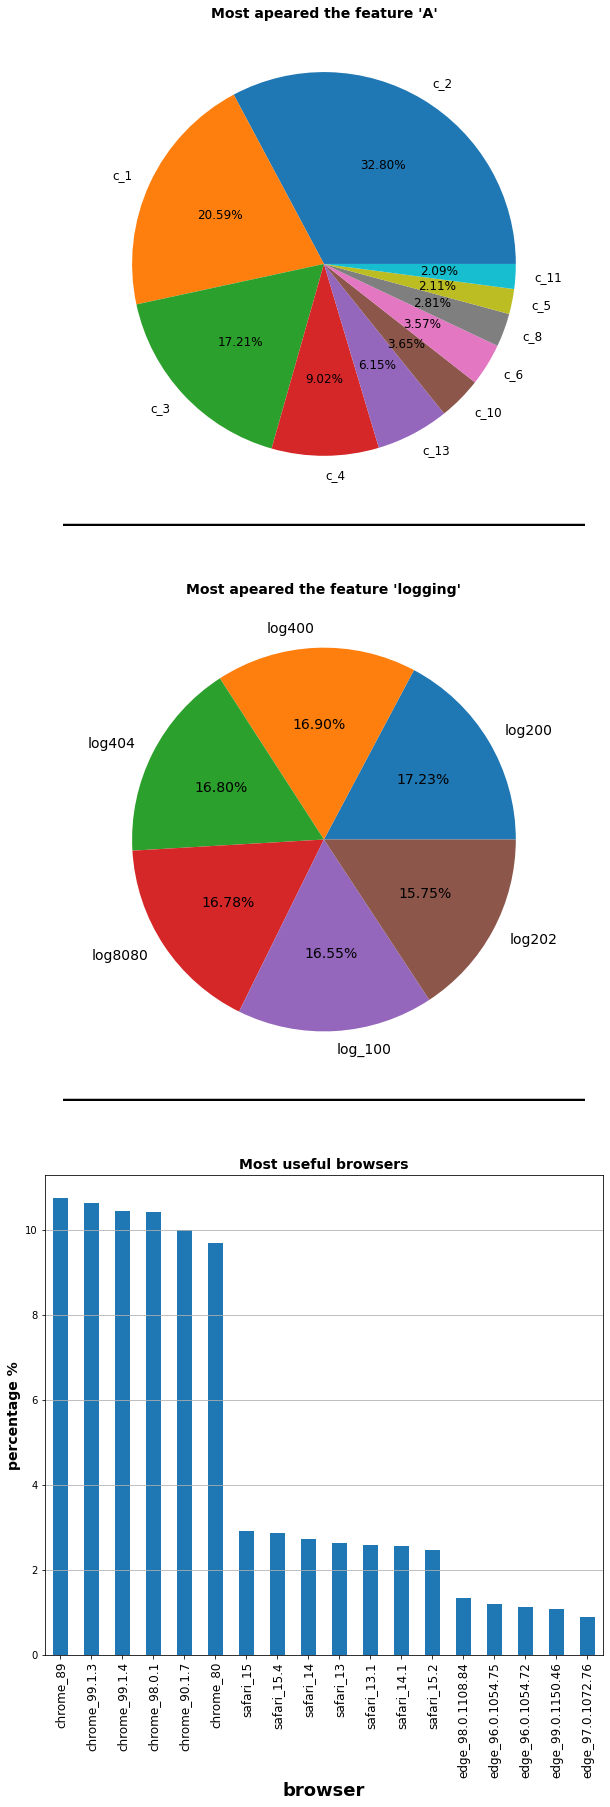

In [457]:
plot_non_numeric()

### what we have done on the chart above


we can see on internet browser feature that a minimum demand of 0.5% browser usage gives us little bit more then 85% of the data. therfore we cant classify it as good filter out future outliers cleaning


### fixing the non_numeric columns.

- "logging" we dont need to touch. we couldn't find outliers according to logging and NAN rate is already 0%
- "A" we need to complete Values and then remove outliers.(details on relevant part)
- "internet browser" we need to convert to only the browsername and then complete the missing values on that way
- convert all non_numeric features to numeric

In [458]:
def no_numeric_complete_and_convert(df:pd.DataFrame):
    df=df.copy()
    for feature in ["internet_browser","a"]:
        a=(X_train[feature].value_counts().sort_values(ascending=False))
        a=round(a*100/a.sum())
        a=a[a>0]
        a_copy=a.copy()
        counter=0
        for i in df[df[feature].isna()].index:
            w=a[a>0]
            if counter>=w.shape[0]:
                counter=0
            df[feature][i]=w.index[counter]
        
            
            a[w.index[counter]]-=1
            counter+=1
            
            
            if not a.max()>0:
                a=a_copy.copy()

    return df

the chart for measuring 'A' feature covers 97.18% of all sampels
the chart for measuring 'logging' feature covers 100% of all sampels
the chart for measuring 'internet browser' feature covers 90.73% of all sampels


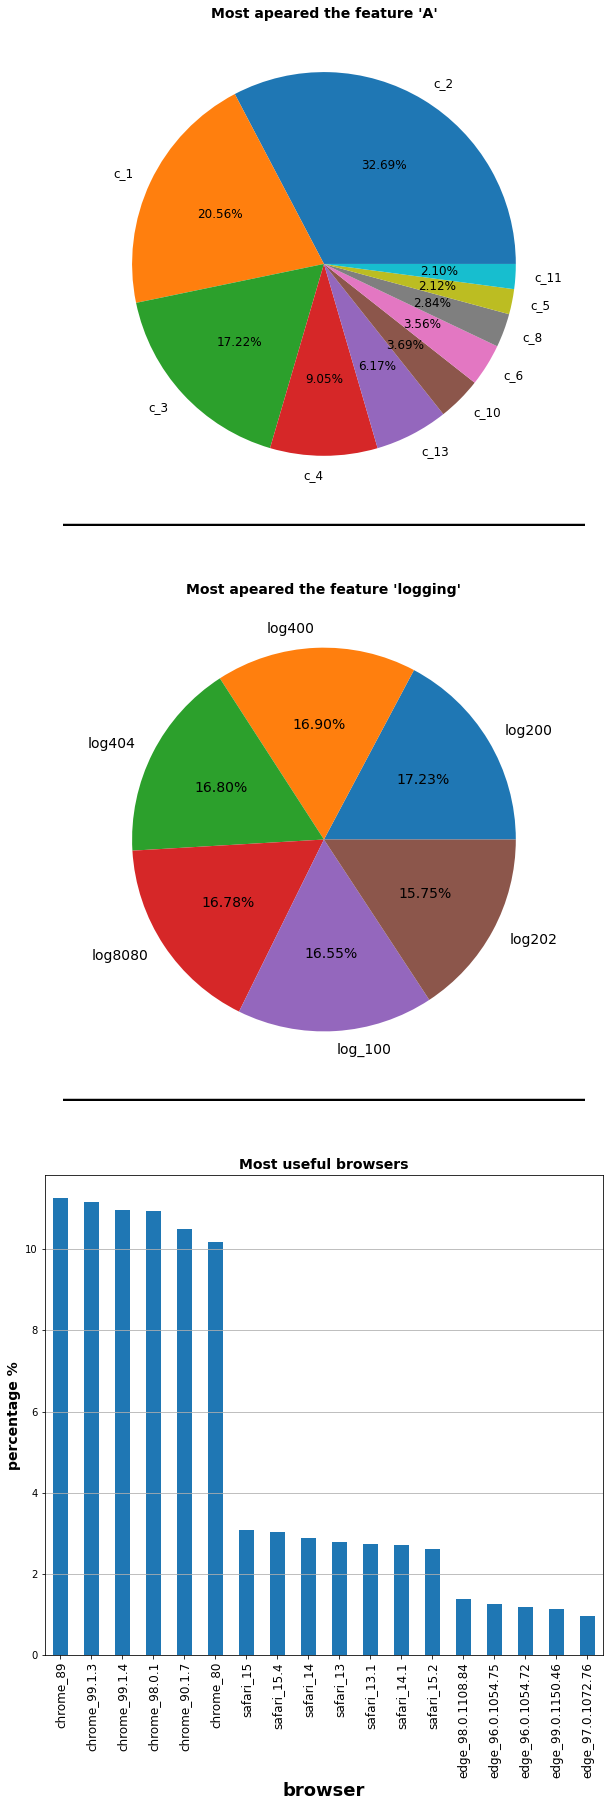

In [459]:
X_train=no_numeric_complete_and_convert(X_train)
X_test=no_numeric_complete_and_convert(X_test)

plot_non_numeric()

We can see significant improvement especially at the "a" feature which those values in the chart, which belong to more then 0.5% of the total train Data,are now constitues more then 97% of total samples.

therfore we can classify as outliers all the samples with values which do not appeare in the chart



# part 2.B removing outliers and convertion of non numeric features

Now after NAN rate reached to 0 we can sort and remove more outliers
- about outliers it is a routine. we clean some outliers, then analyze and complete some data.
- then remove some more outliers (as we alraedy did little bit above) and then complete some more data

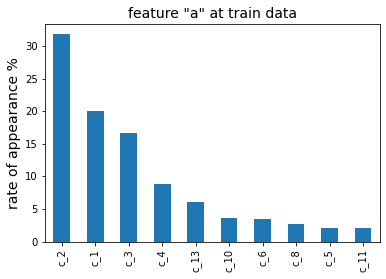

train percentage: 97.18 %


c_2     31.77
c_1     19.98
c_3     16.73
c_4      8.79
c_13     6.00
c_10     3.59
c_6      3.46
c_8      2.76
c_5      2.06
c_11     2.04
Name: a, dtype: float64

In [460]:
d=X_train.a.value_counts().sort_values(ascending=False)
d=100*d/d.sum()
ax=d[d>=0.5].plot(kind='bar',figsize=(6,4))
ax.set_title('feature "a" at train data',fontsize=14)
ax.set_ylabel("rate of appearance %",fontsize=14)
plt.show()
print("train percentage:",round(d[d>0.5].sum(),2),"%")
round(d[d>0.5],2)


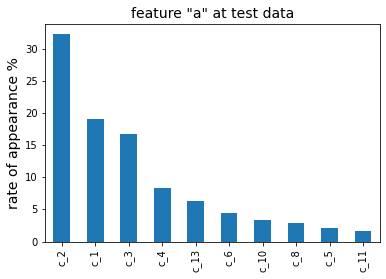

test percentage: 97.24 %


c_2     32.20
c_1     19.12
c_3     16.69
c_4      8.37
c_13     6.37
c_6      4.38
c_10     3.40
c_8      2.92
c_5      2.16
c_11     1.62
Name: a, dtype: float64

In [461]:
d1=X_test.a.value_counts().sort_values(ascending=False)
d1=100*d1/d1.sum()
ax1=d1[d1>0.5].plot(kind='bar',figsize=(6,4))
ax1.set_title('feature "a" at test data',fontsize=14)
ax1.set_ylabel("rate of appearance %",fontsize=14)
plt.show()
print("test percentage:",round(d1[d1>0.5].sum(),2),"%")
round(d1[d1>0.5],2)

### feature "a"
we can see that more then 97% are concentrated to very specific values(train and test).
thefore we will remove all rows which are not with the values at the chart.
because on the training data there are many categories with few rows contains it. which can cause for many problems and increase the variance of our model


therfore we will remove all those outliers which on feature "a" belongs to very small minority

In [462]:
#qw=X_train.a.value_counts().sum
rem_list=X_train.a.value_counts()[((X_train.a.value_counts()/X_train.shape[0])*100)>0.5].index.tolist()
rem_list2=X_test.a.value_counts()[((X_test.a.value_counts()/X_test.shape[0])*100)>0.5].index.tolist()



we will merge all values lower then 0.5% under c_9

In [463]:
X_train.a[(X_train.a.isin(rem_list))==False]='c_9'

X_test.a[(X_test.a.isin(rem_list))==False]='c_9'



In [464]:
#convertion to float
X_train.a=X_train.a.str.replace("c_","")
X_test.a=X_test.a.str.replace("c_","")

X_train.a=X_train.a.astype(float)
X_test.a=X_test.a.astype(float)

### Handling the internet_browsers

if we will remove all of the browsertypes with low appearance we will remove many rows and we dont want that either.
therfore we will concentrate them into browsertypes and remove the version factor

In [465]:
browserlist=["chrome","safari","browser","edge"]
d=1
for i in browserlist:    
    X_train.internet_browser[X_train.internet_browser.str.contains(i)]=i
    X_test.internet_browser[X_test.internet_browser.str.contains(i)]=i

 

convertion to float values

In [466]:
for i in range(len(browserlist)):
    X_train.internet_browser[X_train.internet_browser==browserlist[i]]=i+1 
    X_test.internet_browser[X_test.internet_browser==browserlist[i]]=i+1
#convertion to float    
X_train.internet_browser=X_train.internet_browser.astype(float)   
X_test.internet_browser=X_test.internet_browser.astype(float)

### logging

In [467]:
X_train.logging=X_train.logging.astype(str)
X_test.logging=X_test.logging.astype(str)

X_train.logging=X_train.logging.str.replace("log","").str.replace("_","")
X_test.logging=X_test.logging.str.replace("log","").str.replace("_","")

X_train.logging=X_train.logging.astype(float)
X_test.logging=X_test.logging.astype(float)

for i in X_test.columns:
    X_train[i]=X_train[i].astype(float)
    X_test[i]=X_test[i].astype(float)
X_train.purchase=X_train.purchase.astype(float) 

### now all the train and test data are converted to float lets see if we can remove more outliers

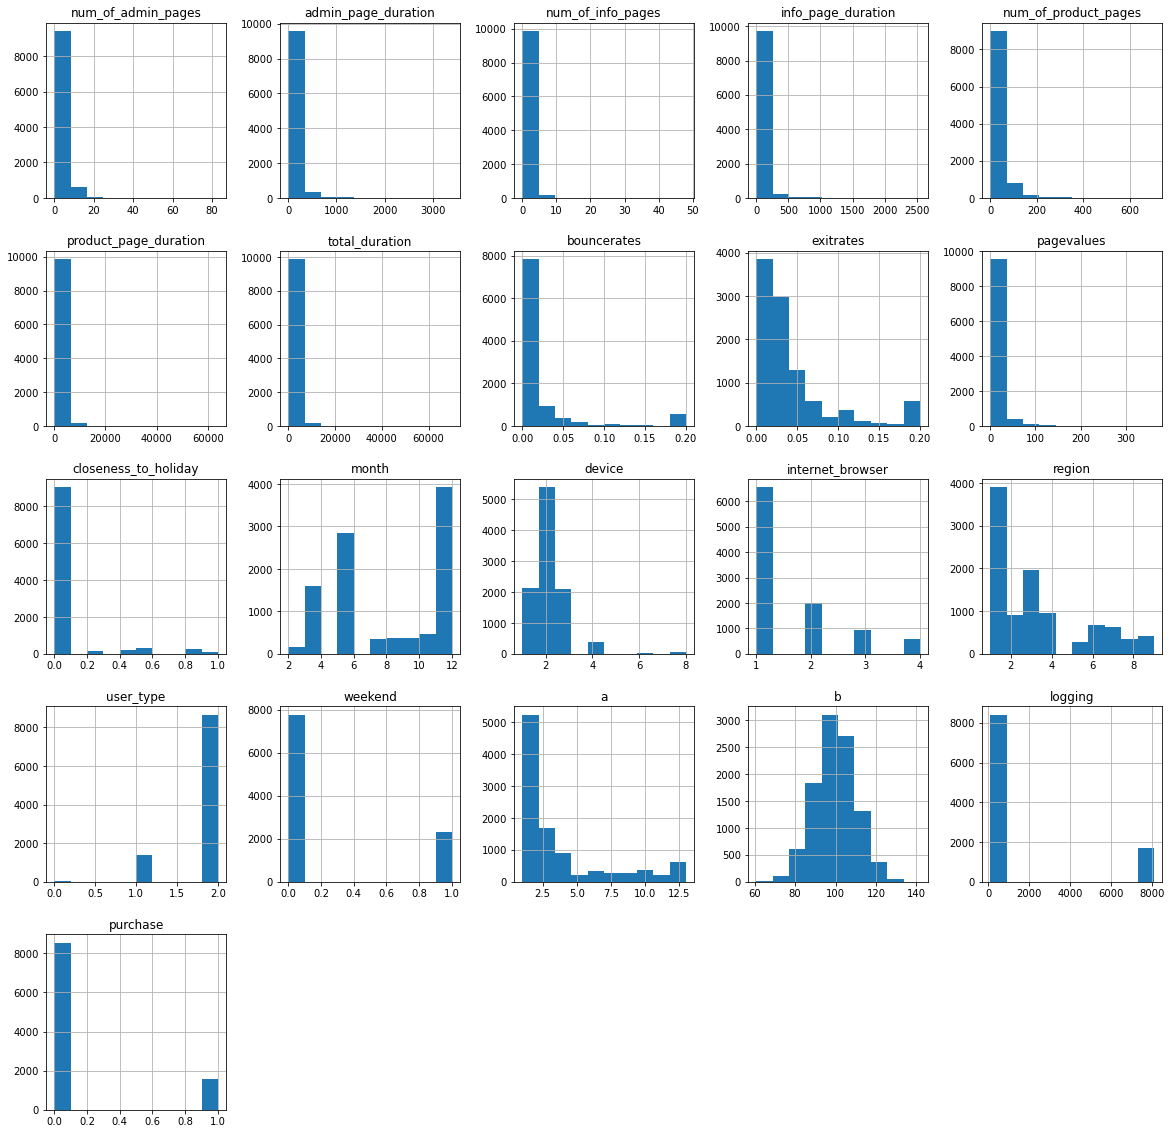

In [468]:
X_train.hist(figsize=(20,20))
plt.show()

#### we can see:
- at "device": we can see on X>4 some outliers
- at logging: that distribution requires a new way of categorizing
- user_type==0 has very low amount

In [469]:
#device

print("train data: \n"+str(X_train.device.value_counts().sort_values())+"\n\ntest Data: \n"+str(X_test.device.value_counts().sort_values()))

train data: 
7.0       3
5.0       4
6.0      18
8.0      61
4.0     388
3.0    2104
1.0    2116
2.0    5403
Name: device, dtype: int64

test Data: 
6.0      1
5.0      1
7.0      3
8.0     14
4.0     75
3.0    381
1.0    394
2.0    982
Name: device, dtype: int64


at train and test data we can see that there very small amount of values(outliers) above 4.

therfore we will remove them and on test data because there few rows we will define them as 4.

In [470]:
X_train=X_train[X_train.device<=4]
X_test.device[X_test.device>=4]=4

### logging

after convertion to float we saw that values behave as numbers. and when we make histogran it presents it at very misleading way,<br> which we afraid will reduce our performance. <br>
hence we will convert them to more friendly numeric values.

In [471]:
X_train.logging.value_counts()

200.0     1722
400.0     1696
8080.0    1678
404.0     1677
100.0     1661
202.0     1577
Name: logging, dtype: int64

In [472]:
#lets convert
logging_list=X_train.logging.value_counts().index.sort_values().tolist()

for i,j in enumerate(logging_list):
    X_train.logging[X_train.logging==j]=float(i)+1
    X_test.logging[X_test.logging==j]=float(i)+1

print("logging:")
# we converted to the values of 1-6
X_train.logging.value_counts()

logging:


2.0    1722
4.0    1696
6.0    1678
5.0    1677
1.0    1661
3.0    1577
Name: logging, dtype: int64

user type

In [473]:
print("train data: \n"+str(X_train.user_type.value_counts().sort_values())+"\n\ntest Data: \n"+str(X_test.user_type.value_counts().sort_values()))

train data: 
0.0      25
1.0    1376
2.0    8610
Name: user_type, dtype: int64

test Data: 
0.0      13
1.0     259
2.0    1579
Name: user_type, dtype: int64


we can remove the outliers, those with the value 0

In [474]:
X_train=X_train[X_train.user_type>0]
r=0
for i in X_test[X_test.user_type==0].index:
    if r<11:
        X_test.loc[i].user_type=2
    else:
        X_test.loc[i].user_type=1
    r+=1

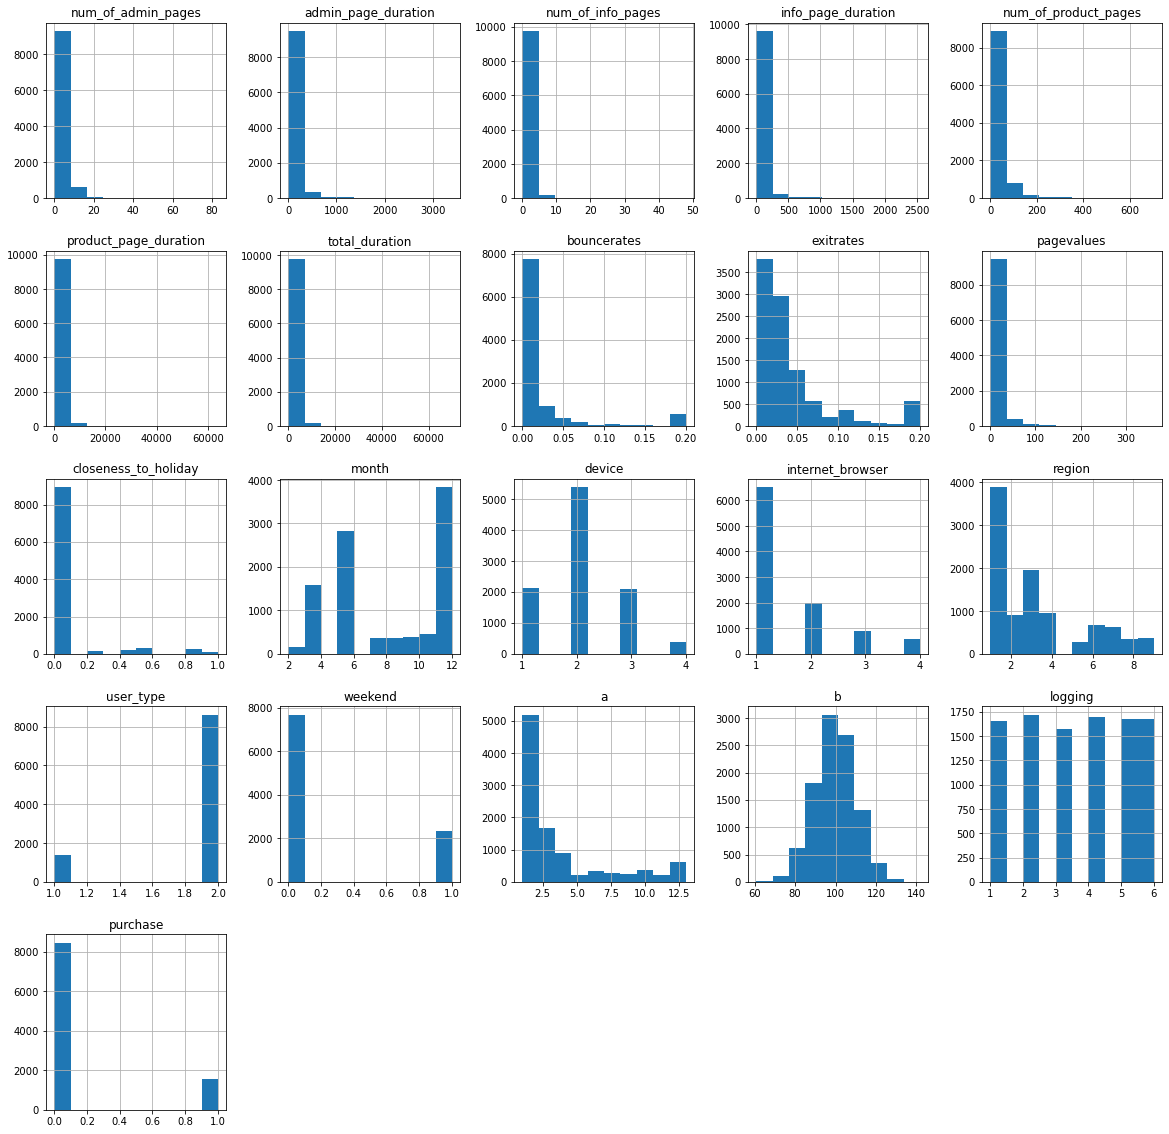

In [475]:
X_train.hist(figsize=(20,20))
plt.show()

In [476]:
X_test.logging.value_counts()

1.0    323
3.0    315
4.0    312
6.0    312
2.0    297
5.0    292
Name: logging, dtype: int64

## Dimentional Reduce

### disadvanteges of high dimentionality
- may cause overfitting due to the reason data is fitted according to many parameters.
- the variance will increase (and bias will "decrease")
- the complexity of the model will be higher which will increase the runtime

#### we can see here many high correlation between different features. therfore we can definitly reduce them!

#### so:


- we will marge the pagestypes to one column "total pages" and remove those 3 columns.
- we will remove all sectorial durations and will remain only with "total duration" 
- we will merge "exitrates" and "bouncerates"( average)
- we will Creat a "PCA" matrix and run with 2 Datas. the PCA matrix and the Data after manual filtering of columns.

In [477]:
strong_correlation(X_train.corr())

Strongest correlations in our train Data:
Correlation between "num_of_admin_pages" and "admin_page_duration" is: 0.902
Correlation between "num_of_admin_pages" and "num_of_info_pages" is: 0.578
Correlation between "num_of_admin_pages" and "info_page_duration" is: 0.521
Correlation between "num_of_admin_pages" and "num_of_product_pages" is: 0.679
Correlation between "num_of_admin_pages" and "product_page_duration" is: 0.659
Correlation between "num_of_admin_pages" and "total_duration" is: 0.694
Correlation between "num_of_admin_pages" and "bouncerates" is: -0.622
Correlation between "num_of_admin_pages" and "exitrates" is: -0.677
Correlation between "admin_page_duration" and "num_of_info_pages" is: 0.552
Correlation between "admin_page_duration" and "info_page_duration" is: 0.526
Correlation between "admin_page_duration" and "num_of_product_pages" is: 0.637
Correlation between "admin_page_duration" and "product_page_duration" is: 0.657
Correlation between "admin_page_duration" and "tota

### on the cell below we will creat 2 versions to compare between.
- first version leaving the data without the PCA convert, but after manual dimentional merge and removal <br>
- second version is the PCA matrix creation

- we have tried to use the Data before dimentional remove, and compare it with PCA and manual reduction.<br>but it didnt work well and performance was too slow with, higher variance
  therfore we marked it with # and it wont be part of the workflow

In [478]:
#modify the train Data

y = X_train['purchase']
y_spare=y
#before_train = X_train.copy()
#before_train = remove_columns(before_train,['purchase'])
after_train = X_train.copy()


#after_train.insert(1, 'tot_pages', after_train.num_of_admin_pages+after_train.num_of_info_pages+after_train.num_of_product_pages)


after_train.insert(8, 'leaving_rate', (after_train.bouncerates+after_train.exitrates)/2)
after_train = remove_columns(after_train,['num_of_admin_pages','num_of_info_pages','num_of_product_pages','admin_page_duration','info_page_duration','product_page_duration','bouncerates','exitrates','purchase'])
#after_train["total_pages"]=before_train[['num_of_admin_pages','num_of_info_pages','num_of_product_pages']].sum(axis=1)

#modify the test data.
#before_test = X_test.copy()
#before_test = remove_columns(before_test,['purchase'])
after_test = X_test.copy()

#after_test.insert(1, 'tot_pages', after_test.num_of_admin_pages+after_test.num_of_info_pages+after_test.num_of_product_pages)
after_test.insert(8, 'leaving_rate', (after_test.bouncerates+after_test.exitrates)/2)
after_test = remove_columns(after_test, ['num_of_admin_pages','num_of_info_pages','num_of_product_pages','admin_page_duration','info_page_duration','product_page_duration','bouncerates','exitrates','purchase'])

In [479]:
strong_correlation(after_train)

Strongest correlations in our train Data:


### split to train and validation

In [480]:
rand_state=42

#before_reduce_raw
#X_train_before_raw ,X_validation_before_raw ,y_train, y_validation = train_test_split(before_train,y,test_size = 0.2, random_state= rand_state, shuffle=True)

#after_reduce_raw
X_train_after_raw ,X_validation_after_raw ,y_train, y_validation = train_test_split(after_train,y,test_size = 0.2, random_state= rand_state, shuffle=True)

# creating the PCA matrix

### components for PCA

In [481]:
def get_principal_components(X: np.array, p: float) -> np.array:
    """
    Returns array of principal components explaining (100*p)% of the variance
    X: 2d numpy array of data we want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    pca = PCA(p)
    pca.fit(X)
    reduced = pca.components_.T
    
    return reduced.transpose()


### Creating the PCA for train, validation and full Data

In [482]:
scaler=StandardScaler()

# train_validation data PCA creat
#X_train_before_scaled=scaler.fit_transform(X_train_before_raw)
X_train_after_scaled=scaler.fit_transform(X_train_after_raw)

#components1=get_principal_components(X_train_before_scaled,0.99)
components2=get_principal_components(X_train_after_scaled,0.99)

#X_validation_before_scaled=scaler.fit_transform(X_validation_before_raw)
X_validation_after_scaled=scaler.fit_transform(X_validation_after_raw)


#X_pca_train_before=np.dot(X_train_before_scaled,components1.T)
X_pca_train_after=np.dot(X_train_after_scaled,components2.T)

#X_pca_validation_before=np.dot(X_validation_before_scaled,components1.T)
X_pca_validation_after=np.dot(X_validation_after_scaled,components2.T)

#real Data raw


X_full_train_raw=after_train
X_full_test_raw=after_test



#real Data PCA
X_full_train_scaled=scaler.fit_transform(X_full_train_raw)
X_full_test_scaled=scaler.fit_transform(X_full_test_raw)

full_components=get_principal_components(X_full_train_scaled,0.99)
X_full_train_pca=np.dot(X_full_train_scaled,full_components.T)
X_full_test_pca=np.dot(X_full_test_scaled,full_components.T)


In [483]:

print(f"for raw Data, num of columns is: {X_full_test_raw.shape[1]}")
print(f"for PCA matrix, num of columns is: {full_components.shape[1]}")


for raw Data, num of columns is: 13
for PCA matrix, num of columns is: 13


### As we can see the PCA method didnt reduce dimentionality

#### creating dictionary which will include all accuracy rates

In [484]:
acc_dic={"logistic_pca":0,"logistic_raw":0,"knn_pca":0,"knn_raw":0}
val_auc_dic={}
train_auc_dic={}

#### creat Dataframe for predict probability of the full Data

In [485]:
df_pred_full=pd.DataFrame()
df_pred_full["id"]=X_full_test_raw.index

# Part 3.A simple models
## we chose to do: k-nn and LogisticRegression

# logistic regression

In [486]:
def logistic_data():

    
        
    #X_t_b=X_train_before_raw
    
    #X_v_b=X_validation_before_raw


    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after



    #X_t_b=X_pca_train_before
    #X_v_b=X_pca_validation_before
    powers = range(-3,1)
    Cs = [10**p for p in powers]
    penalty_type=['l1','l2']
    #max_acc=0
    #penalty=""
    #solver="liblinear"
    
    c_max=0
    fig,ax=plt.subplots(1,2,figsize=(15,6))
    acc_dic_raw={"max_acc":0,"penalty":"","C":0,"solver":"liblinear"}
    acc_dic_pca={"max_acc":0,"penalty":"","C":0,"solver":"liblinear"}

    chl=["raw","pca"]

    for i,j in enumerate(penalty_type):
        #score_before=[]
        score_raw=[]
        score_pca=[]
        for c in Cs:
            

            reg_raw=LogisticRegression(penalty=j,solver='liblinear',C=c)
            #reg2=LogisticRegression(penalty=j,solver='liblinear',C=c)
            reg_pca=LogisticRegression(penalty=j,solver='liblinear',C=c)
                
            #fitting    
            reg_raw.fit(X_t_raw,y_train)
            reg_pca.fit(X_t_pca,y_train)


            #reg2.fit(X_t_a,y_train)
            
            #score_before.append(reg1.score(X_v_b,y_validation))
            #if reg1.score(X_v_b,y_validation)>max_acc:
                #max_acc=reg1.score(X_v_b,y_validation)
                #penalty=j
                #timing="before"
                #c_max=c
            

            #score raw#
            score_raw.append(reg_raw.score(X_v_raw,y_validation))
            if reg_raw.score(X_v_raw,y_validation)>=acc_dic_raw["max_acc"]:
                acc_dic_raw["max_acc"]=reg_raw.score(X_v_raw,y_validation)
                acc_dic_raw["penalty"]=j
                acc_dic_raw["C"]=c

            #score pca
            score_pca.append(reg_pca.score(X_v_pca,y_validation))
            if reg_pca.score(X_v_pca,y_validation)>=acc_dic_pca["max_acc"]:
                acc_dic_pca["max_acc"]=reg_pca.score(X_v_pca,y_validation)
                acc_dic_pca["penalty"]=j
                acc_dic_pca["C"]=c
            

        #plot
        ax[i].plot(powers,score_raw,color="b",label="acc raw data")
        ax[i].plot(powers,score_pca,color="r",label="acc PCA matrix")
        ax[i].set_title('accuracy with '+(j.upper())+' penalty')
        ax[i].legend(loc=4)
        
    #feeding at the global acc dictionary    
    acc_dic["logistic_pca"]=acc_dic_pca["max_acc"]
    acc_dic["logistic_raw"]=acc_dic_raw["max_acc"]

    
    print(f'max pca accuracy is: {acc_dic_pca["max_acc"]}\nwith penatly type: {acc_dic_pca["penalty"]}\nc value is: {acc_dic_pca["C"]}\nsolver is: {acc_dic_pca["solver"]}\n')
    print(f'max raw data accuracy is: {acc_dic_raw["max_acc"]}\nwith penatly type: {acc_dic_raw["penalty"]}\nc value is: {acc_dic_raw["C"]}\nsolver is: {acc_dic_raw["solver"]}')
    



    # fit full data and save predictions
    reg_full_pca=LogisticRegression(penalty=acc_dic_pca["penalty"],solver=acc_dic_pca["solver"],C=acc_dic_pca["C"])
    reg_full_raw=LogisticRegression(penalty=acc_dic_raw["penalty"],solver=acc_dic_raw["solver"],C=acc_dic_raw["C"])

    reg_full_pca.fit(X_full_train_pca,y)
    reg_full_raw.fit(X_full_train_raw,y)

    #prediction
    df_pred_full["logistic_pca"]=reg_full_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["logistic_raw"]=reg_full_raw.predict_proba(X_full_test_raw)[:,1]
    

    # train AUC

    fpr, tpr, thresholds = roc_curve(y, reg_full_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['logistic_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, reg_full_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['logistic_raw']=auc(fpr, tpr)#RAW


        
        
        
    # check the validation AUC
    reg_set_pca=LogisticRegression(penalty=acc_dic_pca["penalty"],solver=acc_dic_pca["solver"],C=acc_dic_pca["C"])
    reg_set_raw=LogisticRegression(penalty=acc_dic_raw["penalty"],solver=acc_dic_raw["solver"],C=acc_dic_raw["C"])
    
    #pca
    reg_set_pca.fit(X_t_pca,y_train)

    fpr, tpr, thresholds = roc_curve(y_validation, reg_set_pca.predict_proba(X_v_pca)[:,1])
    val_auc_dic['logistic_pca']=auc(fpr, tpr)#PCA

    #raw
    reg_set_raw.fit(X_t_raw,y_train)
    fpr, tpr, thresholds = roc_curve(y_validation, reg_set_raw.predict_proba(X_v_raw)[:,1])
    val_auc_dic['logistic_raw']=auc(fpr, tpr)#RAW


    plt.show()
    return reg_set_raw,reg_set_pca

### now lets test the logistic regression on the raw data before PCA procedure!


max pca accuracy is: 0.8868868868868869
with penatly type: l2
c value is: 1
solver is: liblinear

max raw data accuracy is: 0.8848848848848849
with penatly type: l2
c value is: 1
solver is: liblinear


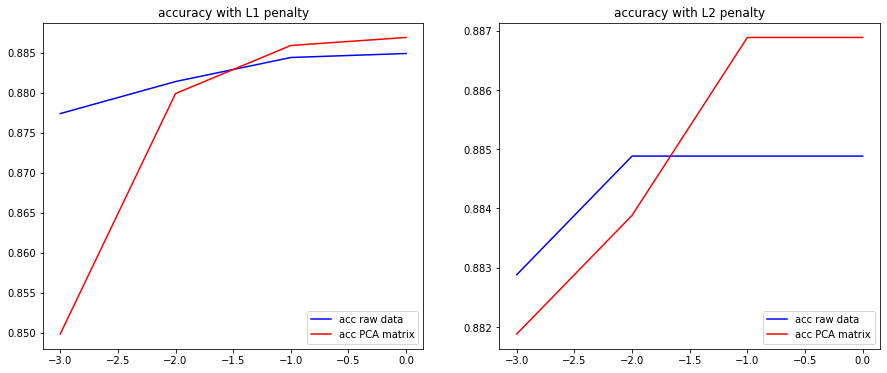

In [487]:
logistic_train_set_raw,logistic_train_set_pca=logistic_data()

## best hyper parameters for logisticregression:

### pca:
- C=1
- solver="liblinear"
- penalty="l2"
<br>

### raw:
- C=1
- solver="liblinear"
- penalty="l2"<br>


# KNN

### here we will perform KNN method.

In [488]:
def KNN_model(ctype):

    min_test_mse = 'NULL'

    if ctype=="raw":
        X_t=X_train_after_raw
        X_v=X_validation_after_raw
        X_test = X_pca_validation_after
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot raw':   
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation

    elif ctype=='pca':  
        X_t = X_pca_train_after
        X_v = X_pca_validation_after
        X_test = X_pca_validation_after
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot pca':  
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation

    else:
        print("please choose right classifier")
        return
    
    neighbors = np.arange(1, 23)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))


    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_t, Y_t)

        train_accuracy[i] = knn.score(X_t, Y_t)
        test_accuracy[i] = knn.score(X_v, Y_v)

        #if(test_accuracy[i]>max_acc):
        #    max_acc = test_accuracy[i]
        #    max_k =k
        #    test_preds = knn.predict(X_v)
        #    min_mse_test = mean_squared_error(y_validation, test_preds)

        #train_preds = knn.predict(X_t)
        #mse_train = mean_squared_error(y_train, train_preds)
        #rmse_train = sqrt(mse_train)

        #test_preds = knn.predict(X_v)
        #min_mse_test = mean_squared_error(y_validation, test_preds)
        #rmse_test = sqrt(mse_test)

        #overfitting = rmse_test - rmse_train
        #if(mse_test<min_test_mse):
        #    min_test_mse = mse_test
            #min_k = k

    max_acc = max(test_accuracy)
    max_k = np.unravel_index(np.argmax(test_accuracy),test_accuracy.shape)[0] + 1
    key = 'knn_'+ctype
    acc_dic[key] = max_acc
    knn = KNeighborsClassifier(n_neighbors=max_k)
    knn.fit(X_t, Y_t)
    test_preds = knn.predict(X_test)
    if('tot' not in ctype):
        min_test_mse = mean_squared_error(Y_v, test_preds)
    
    print(f'{ctype}:\nmin mse={min_test_mse}\nbest accuracy k={max_k}\naccuracy={max_acc}')

    plt.plot(test_accuracy, label = 'Testing dataset Accuracy')
    plt.plot(train_accuracy, label = 'Training dataset Accuracy')
    
    plt.legend()
    plt.title(ctype)
    plt.xlabel('n_neighbors')
    plt.ylabel('Accuracy')

    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after

    # fit full data and save predictions
    knn_full_pca=KNeighborsClassifier(n_neighbors=max_k)
    knn_full_raw=KNeighborsClassifier(n_neighbors=max_k)

    knn_full_pca.fit(X_full_train_pca,y)
    knn_full_raw.fit(X_full_train_raw,y)

    #prediction
    df_pred_full["knn_pca"]=knn_full_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["knn_raw"]=knn_full_raw.predict_proba(X_full_test_raw)[:,1]
    
    # train AUC
    fpr, tpr, thresholds = roc_curve(y, knn_full_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['knn_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, knn_full_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['knn_raw']=auc(fpr, tpr)#RAW

    # check the validation AUC
    knn_set_pca=KNeighborsClassifier(n_neighbors=max_k)
    knn_set_raw=KNeighborsClassifier(n_neighbors=max_k)
    
    #pca
    knn_set_pca.fit(X_t_pca,y_train)

    fpr, tpr, thresholds = roc_curve(y_validation, knn_set_pca.predict_proba(X_v_pca)[:,1])
    val_auc_dic['knn_pca']=auc(fpr, tpr)#PCA

    #raw
    knn_set_raw.fit(X_t_raw,y_train)
    fpr, tpr, thresholds = roc_curve(y_validation, knn_set_raw.predict_proba(X_v_raw)[:,1])
    val_auc_dic['knn_raw']=auc(fpr, tpr)#RAW

    plt.show()
    
    return knn

raw:
min mse=0.15015015015015015
best accuracy k=9
accuracy=0.8838838838838838


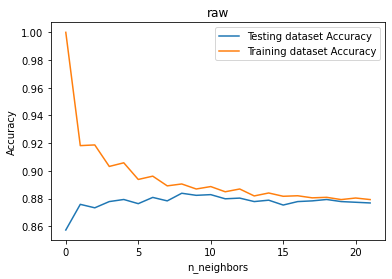

tot raw:
min mse=NULL
best accuracy k=2
accuracy=0.8888888888888888


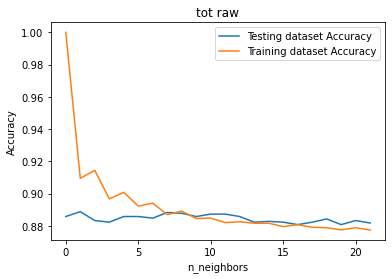

pca:
min mse=0.12162162162162163
best accuracy k=7
accuracy=0.8783783783783784


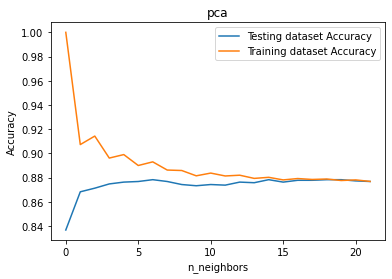

tot pca:
min mse=NULL
best accuracy k=2
accuracy=0.8888888888888888


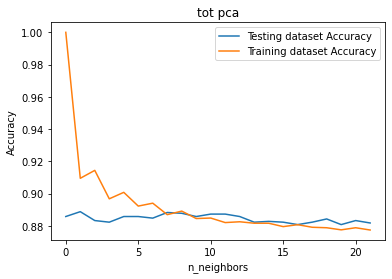

In [489]:
knn_raw = KNN_model("raw")
knn_full_pca = KNN_model("tot raw")
knn_pca = KNN_model('pca')
knn_full_pca = KNN_model('tot pca')

## The best K value for the train data is "2"
That is the hyperparameter we've used:


# Part 3.B complicated Models

## RandomForestClassifier

In [490]:
def forest_classifier_CV():

    # parameters dictionary

    parameters={"n_estimators":[40,50],'criterion':["entropy","gini"],"max_depth":[2,3,4,5,None]}
    #defining the variables
    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after
    #-------------------------------------------------------------------
    #this part we will run on the full data
    forest_classfier_pca=RandomForestClassifier(random_state=0)
    forest_classfier_raw=RandomForestClassifier(random_state=0)

    #forest_classfier_pca.fit(X_full_train_pca,y)# full data here
    #forest_classfier_raw.fit(X_full_train_raw,y)# full data here
    
    gscv_pca=GridSearchCV(forest_classfier_pca, parameters, scoring='roc_auc')#pre training on full Data(train + validation)
    gscv_raw=GridSearchCV(forest_classfier_raw, parameters, scoring='roc_auc')#pre training on full Data(train + validation)

    gscv_raw.fit(X_full_train_raw,y)
    gscv_pca.fit(X_full_train_pca,y)

    # prediction and sendin to the Dataset
    
    df_pred_full["forest_pca"]=gscv_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["forest_raw"]=gscv_raw.predict_proba(X_full_test_raw)[:,1]
        
        
        # train AUC
    fpr, tpr, thresholds = roc_curve(y, gscv_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['forest_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, gscv_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['forest_raw']=auc(fpr, tpr)#RAW


    #-------------------------------------------------------------------
    # in order to be sure on our model we will run the same process again without any attach with validation set.add
    # you can see here validation is not involve at all on that part here. "nov" means "no validation"
    forest_classfier_pca_nov=RandomForestClassifier(random_state=0)
    forest_classfier_raw_nov=RandomForestClassifier(random_state=0)
    
    #forest_classfier_raw_nov.fit(X_t_raw,y_train)
    #forest_classfier_pca_nov.fit(X_t_pca,y_train)

    gscv_pca_nov=GridSearchCV(forest_classfier_pca, parameters, scoring='roc_auc')#only train set. without validation
    gscv_raw_nov=GridSearchCV(forest_classfier_raw, parameters, scoring='roc_auc')#only train set. without validation

    gscv_raw_nov.fit(X_t_raw,y_train)
    gscv_pca_nov.fit(X_t_pca,y_train)



    # validation AUC
    fpr, tpr, thresholds = roc_curve(y_validation, gscv_pca_nov.predict_proba(X_v_pca)[:,1])
    val_auc_dic['forest_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y_validation, gscv_raw_nov.predict_proba(X_v_raw)[:,1])
    val_auc_dic['forest_raw']=auc(fpr, tpr)#RAW

    #-------------------------------------------------------------------------------


    
    #parameters={"n_estimators":[4,20,30,200],'criterion':["entropy","gini"],"max_depth":[2,3,4,5,None]}

    #define GridSearchCV
    

    #fit

    
    return gscv_pca,gscv_raw,gscv_raw_nov,gscv_pca_nov

In [491]:
gscv_pca,gscv_raw,gscv_raw_nov,gscv_pca_nov=forest_classifier_CV()

In [492]:
print(f"best hyper parameters for RandomForestClassifier with PCA matrix:\n{gscv_pca.best_params_}")
print("\n")
print(f"best hyper parameters for RandomForestClassifier with raw data:\n{gscv_raw.best_params_}")

best hyper parameters for RandomForestClassifier with PCA matrix:
{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 50}


best hyper parameters for RandomForestClassifier with raw data:
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 50}


## best hyper parameters for RandomForestClassifier

### PCA:
- 'criterion'= 'entropy'
- 'max_depth'= None
- 'n_estimators': 50

### RAW DATA:

- 'criterion'= 'gini'
- 'max_depth'= 5
- 'n_estimators'= 50

on both we put random_state as 0

### here when validation is involved at the fit of RandomForestClassifier

meaning is when we trained the full DATASET (train + validation)

In [493]:
# when validation is involved
print("When validation is involved at the fitting process:\n")




print (f"\npca train accuracy is: {gscv_pca.score(X_pca_train_after,y_train)}")
print (f"pca validation accuracy is: {gscv_pca.score(X_pca_validation_after,y_validation)}")

print (f"\nraw train accuracy is: {gscv_raw.score(X_train_after_raw,y_train)}")
print (f"raw validation accuracy is: {gscv_raw.score(X_validation_after_raw,y_validation)}")

When validation is involved at the fitting process:


pca train accuracy is: 0.9428432400817865
pca validation accuracy is: 0.9406566548881037

raw train accuracy is: 0.9290023805737557
raw validation accuracy is: 0.9270278759324695


### here when validation is **not** involved at the fit of RandomForestClassifier

Means when we trained pnly the train set.(without validation)

In [494]:
print("When validation is 'not' involved at the fitting process\n")





print (f"\npca train accuracy is: {gscv_pca_nov.score(X_pca_train_after,y_train)}")
print (f"pca validation accuracy is: {gscv_pca_nov.score(X_pca_validation_after,y_validation)}")

print (f"\nraw train accuracy is: {gscv_raw_nov.score(X_train_after_raw,y_train)}")
print (f"raw validation accuracy is: {gscv_raw_nov.score(X_validation_after_raw,y_validation)}")


acc_dic["forest_raw"]=gscv_raw_nov.score(X_validation_after_raw,y_validation)
acc_dic["forest_pca"]=gscv_pca_nov.score(X_pca_validation_after,y_validation)
    

When validation is 'not' involved at the fitting process


pca train accuracy is: 0.9999998213229605
pca validation accuracy is: 0.8861052218296035

raw train accuracy is: 1.0
raw validation accuracy is: 0.9140488810365135


### about RandomForestClassifier:
it is very importat to mention that in that model there isnt overfitting. as much trees as possible as better results we get.<br> but we need to remember that running time is a factor and therfore we should take as much n_estimators as we can as long as we are in the timeframe.




## Multi Layer Perceptron (MLP)

In [495]:
def MLP_model(ctype): 
    if ctype=="raw":
        X_t=X_train_after_raw
        X_v=X_validation_after_raw
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot raw':   
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation
    
    elif ctype=='pca':  
        X_t = X_pca_train_after
        X_v = X_pca_validation_after
        X_test = X_pca_validation_after
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot pca':  
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation

    else:
        print("please choose right classifier")
        return
    
    clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(6,), 
                    random_state=1)

    clf.fit(X_t, Y_t) 
    clf.score(X_v, Y_v) 

    predictions_train = clf.predict(X_t)
    predictions_test = clf.predict(X_v)
    train_score = accuracy_score(predictions_train, Y_t)
    print(f'score on {ctype} train data: {train_score}')
    test_score = accuracy_score(predictions_test, Y_v)
    print(f'score on {ctype} test data: {test_score}')

    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after
    
    # fit full data and save predictions
    mlp_full_pca=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)
    mlp_full_raw=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)

    mlp_full_pca.fit(X_full_train_pca,y)
    mlp_full_raw.fit(X_full_train_raw,y)

    #prediction
    df_pred_full["mlp_pca"]=mlp_full_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["mlp_raw"]=mlp_full_raw.predict_proba(X_full_test_raw)[:,1]
    
    # train AUC
    fpr, tpr, thresholds = roc_curve(y, mlp_full_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['mlp_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, mlp_full_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['mlp_raw']=auc(fpr, tpr)#RAW

    # check the validation AUC
    mlp_set_pca=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)
    mlp_set_raw=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)
    
    #pca
    mlp_set_pca.fit(X_t_pca,y_train)

    fpr, tpr, thresholds = roc_curve(y_validation, mlp_set_pca.predict_proba(X_v_pca)[:,1])
    val_auc_dic['mlp_pca']=auc(fpr, tpr)#PCA

    #raw
    mlp_set_raw.fit(X_t_raw,y_train)
    fpr, tpr, thresholds = roc_curve(y_validation, mlp_set_raw.predict_proba(X_v_raw)[:,1])
    val_auc_dic['mlp_raw']=auc(fpr, tpr)#RAW

    return clf

In [496]:
mlp_raw = MLP_model('raw')
mlp_pca = MLP_model('pca')
mlp_full_raw = MLP_model('tot raw')
clf_full_pca = MLP_model('tot pca')

score on raw train data: 0.8859539308963446
score on raw test data: 0.8833833833833834
score on pca train data: 0.8982223335002504
score on pca test data: 0.8913913913913913
score on tot raw train data: 0.9036651311836571
score on tot raw test data: 0.7907907907907908
score on tot pca train data: 0.9036651311836571
score on tot pca test data: 0.7907907907907908


The hyperparameters we used in MLPclassifier are:
 - solver='lbfgs'
 - alpha=1e-5
 - hidden_layer_sizes=(6,)
 - random_state=1
        

In [497]:
print ("AUC Scores:")

val_auc_dic

AUC Scores:


{'logistic_pca': 0.8960188457008245,
 'logistic_raw': 0.886676482135846,
 'knn_pca': 0.7185698861405576,
 'knn_raw': 0.7479544562230075,
 'forest_pca': 0.8861052218296035,
 'forest_raw': 0.9140488810365135,
 'mlp_pca': 0.9155673341185708,
 'mlp_raw': 0.9021162151550844}

WE can see that MLP on the PCA data has the highest AUC score

# part 4.A : confussion matrix

Test Accuracy: 
 0.8888888888888888


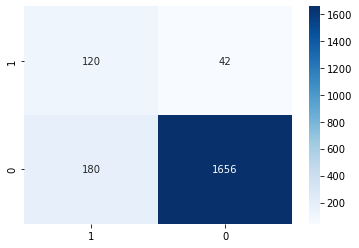

In [498]:
# train the model
gscv_pca_nov.fit(X_pca_train_after, y_train)

y_pred = gscv_pca_nov.predict(X_pca_validation_after)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred)

tn, fp, fn, tp = cf_matrix.ravel()
cf_matrix = np.array([[tp,fp],[fn,tn]])
print("Test Accuracy: \n", (tp+tn) / cf_matrix.sum())
sns.heatmap(cf_matrix,annot=True,fmt='g',cmap='Blues', xticklabels = [1,0], yticklabels = [1,0])
plt.show()

# PART 4.B: roc-curve plot

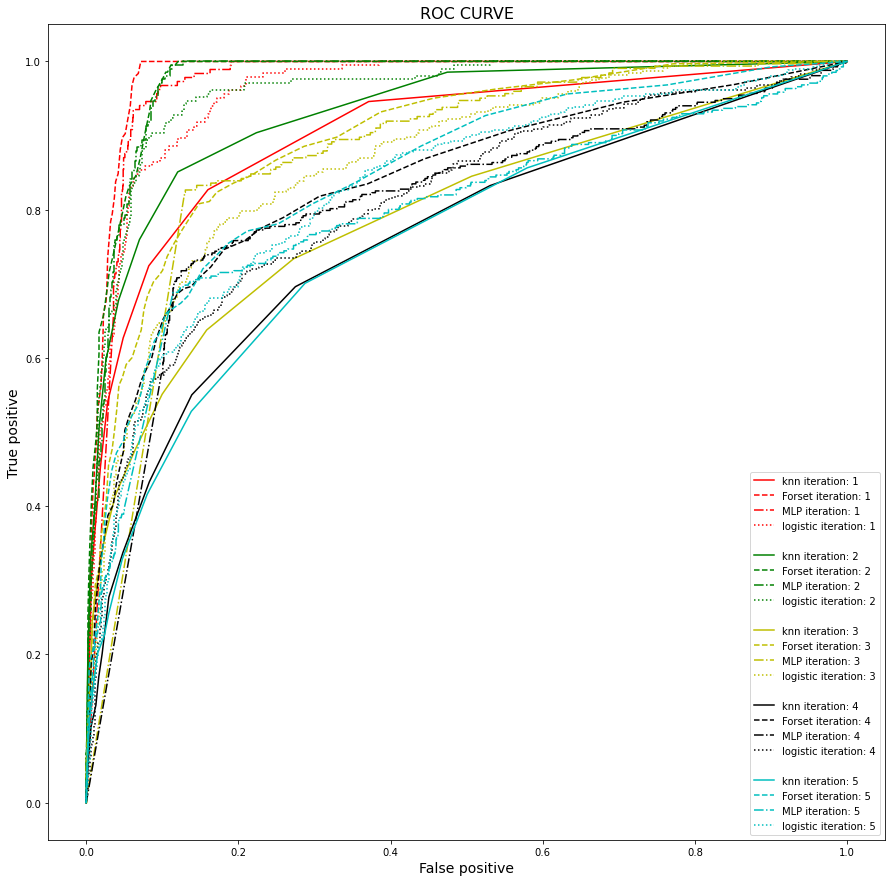

In [499]:
ford=gscv_raw_nov.best_params_
X_tr=X_full_train_raw.copy()

X_tr_pca=X_full_train_pca.copy()
forest_raw=RandomForestClassifier(n_estimators=ford["n_estimators"],criterion=ford['criterion'],max_depth=ford["max_depth"],random_state=0)

ford=gscv_pca_nov.best_params_
forest_pca=RandomForestClassifier(n_estimators=ford["n_estimators"],criterion=ford['criterion'],max_depth=ford["max_depth"],random_state=0)


MLP_raw=MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(6,),random_state=1)
MLP_pca=MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(6,),random_state=1)

knn_raw= KNeighborsClassifier(n_neighbors=12)  
knn_pca= KNeighborsClassifier(n_neighbors=12) 

log_raw=LogisticRegression(C=0.1,penalty="l2",solver="liblinear")
log_pca=LogisticRegression(C=0.1,penalty="l2",solver="liblinear")

modelist_raw=[knn_raw,forest_raw,MLP_raw,log_raw]
m_r_l=["knn","Forset","MLP","logistic"]
ls=["-","--","-.",":"]
colors=["r","g","y","k","c"]

avarage_array=[]
plt.figure(figsize=(15,15))


kf=KFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(X_tr)
d=0
g=0
for train_index, test_index in kf.split(X_tr):
    
    Xk_train, Xk_test = X_tr.iloc[train_index], X_tr.iloc[test_index]
    yk_train, yk_test = y_spare.iloc[train_index], y_spare.iloc[test_index]
    d+=1
    i=0
    
    for model in modelist_raw:
        model.fit(Xk_train,yk_train)
        fpr, tpr, _ = roc_curve(yk_test,  model.predict_proba(Xk_test)[:,1])
        plt.plot(fpr,tpr,label=m_r_l[i]+" iteration: "+str(d),linestyle=ls[i],color=colors[g])
        i+=1
    g+=1

    if g!=5:
        plt.plot([0,0],[0,0],label=" ",color="white")    


plt.title("ROC CURVE",fontsize=16)        
plt.xlabel("False positive",fontsize=14) 
plt.ylabel("True positive",fontsize=14) 
plt.legend()
plt.show()

## regarding to overfitting

looks like the AUC score is quite high at most of the curves.
especially at the RandomForest model, and that is why it is our selected model.
The special thing about the RandomForest algorithm is it doesn't have overfitting (and if there is it's quite small).




# PART 5

in that part after collected the AUC's accuracies, and predictions we will check and decide what model gave the best results and decide to put it at the submittion CSV.

In [500]:
chosen=[0,0]
for i in val_auc_dic:
    if val_auc_dic[i]>chosen[1]:
        chosen[0]=i
        chosen[1]=val_auc_dic[i]

df_pred_full["predict_prob"]=df_pred_full[chosen[0]]

dfg=df_pred_full[["id","predict_prob"]]
dfg.to_csv("Submission_group_18.csv",index=False)
        

In [501]:
X_full_train_raw.to_csv("full data.csv")

# PIPELINE

In [502]:
# import
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import auc, roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve, confusion_matrix
from IPython.display import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from math import sqrt
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os
import re
import time
import random
import colorama
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

# creating bold affect
t0=time.time()
bold='\033[1m{}\033[0m'
bold=bold.format

underline="\u0332".join

# first Data cleaning function
def clean_data(df:pd.DataFrame):



    #variables define
    months = {"Jan":1, "Feb":2, "Mar":3,"Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
    num_rows = df.shape[0]
    user_type = {"Returning_Visitor":2.00, "New_Visitor":1.00, "Other":0.00}
    pattern = r'[^0-9.]+'

    #replace NAN at duration cell with 0 wherever num of pages == 0
    df["info_page_duration"][df.num_of_info_pages==0]=0
    df["admin_page_duration"][df.num_of_admin_pages==0]=0
    df["product_page_duration"][df.num_of_product_pages==0]=0

    # convert the weekend feature to numeric values.
    df.Weekend[df.Weekend==False]=0.00
    df.Weekend[df.Weekend==True]=1.00
    df.Weekend=df.Weekend.astype(float)
    
    
    for i in user_type:
        df["user_type"][df["user_type"]==i]=user_type[i]
    df["user_type"]=df["user_type"].astype(float)  


    for i in range(num_rows):
        #convertion to float
        if(isinstance(df.info_page_duration[i], str)):
            df.info_page_duration[i] = float(re.sub(pattern, '', df.info_page_duration[i]))
        
        if(isinstance(df.product_page_duration[i], str)):    
            df.product_page_duration[i] = float(re.sub(pattern, '', df.product_page_duration[i]))
            
        
        
        #changing the month
        df.Month[i] = months.get(df.Month[i])

        # modify the times
        prod = df.product_page_duration[i]
        info = df.info_page_duration[i]
        admin = df.admin_page_duration[i]
        tot = df.total_duration[i]
        
        #the duration times fixing
        if(pd.isna(tot)):
            if(pd.isna(prod) or pd.isna(info) or pd.isna(admin)):
                continue
            df.total_duration[i] = prod + info + admin
        elif(pd.isna(prod)):
            if(pd.isna(info) or pd.isna(admin)):
                continue
            df.product_page_duration[i] = tot - info - admin
        elif(pd.isna(info)):
            if(pd.isna(admin)):
                continue
            df.info_page_duration[i] = tot - prod - admin
        elif(pd.isna(admin)):
            df.admin_page_duration[i] = tot - prod - info
    # ----------------------------------------------------------------

    #end of loop
    
    #convert columns into lowercase
    df.columns = [col.lower() for col in df]


    #convert page durations into float type
    df[['product_page_duration', 'info_page_duration']]=df[['product_page_duration', 'info_page_duration']].astype(float)
    
    # change the c column into logging
    df.rename(columns = {'c':"logging"}, inplace = True)
    
    #convert months into float mode
    df.month=df.month.astype(float)
    return df


#remove columns(features)
def remove_columns(df:pd.DataFrame,features_to_remove_list):
    #case for feature list
    lst=[]
    for i in features_to_remove_list:
        if i in df.columns:
            lst.append(i)

    #case for single feature        
    if type(features_to_remove_list)==str:
        if features_to_remove_list in df.columns:
            lst.append (features_to_remove_list)  

    if lst==[]:
        print("nothing been removed")         
    return df.drop(lst,axis=1)


#remove rows    
def remove_rows(df:pd.DataFrame,indexes_to_remove):
    
    #case for feature list
    lst=[]
    for i in indexes_to_remove:
        if i in df.index:
            lst.append(i) 

    #case for single feature
    if type(indexes_to_remove)==str:
        if indexes_to_remove in df.columns:
            lst.append (indexes_to_remove) 

    if lst==[]:
        print("nothing been removed. maybe because ")        
    return df.drop(lst,axis=0) 

# calculate apearance rate
def create_apeare(df:pd.DataFrame):
    '''
    this function checks the probability that
    from all rows that page_type is not NAN and duration is 0
    a specific amount of pages is the real amount
    and creats a rounded probability list according to indexes
    '''

    page_name=df.columns[0]
    col_time=df.columns[1]
    d=df[page_name][ (df[col_time]==0) &(df[page_name].notna())].value_counts().sort_index()
    apeare=[0 for i in range (int(d.index.max()+1))]
    for i,j in enumerate(d):
        apeare[int(d.index[i])]=j

    # build a probability list. from 100 samples with 0.0 duration time 
    sum_appear=sum(apeare) 
    apeare_rate=[0 for i in range(len(apeare))]  
    for i,j in enumerate(apeare):
        apeare_rate[i]=round(apeare[i]*100/sum_appear)    
    return apeare_rate

# filling the time missing values
def time_filling(df:pd.DataFrame,di:pd.DataFrame):  
 
    df=df.copy()
    pages=['num_of_admin_pages','num_of_info_pages','num_of_product_pages']
    times=[]
    for i in df.columns:
        if "duration" in i:
            times.append(i)
    
    for index,page_name in enumerate(pages):
        #set
        col_time=times[index] #our duration which is connected to the type of pages.

        

        #-----------set 1---------------- 

        # set 1 is for cases which duration is 0 and pagetye is NAN
         
         
          
        apeare_rate=create_apeare(X_train[[page_name,col_time]])
        apeare_rate_copy=np.array(apeare_rate.copy())
        
        
        for i,j in enumerate(df[ (df[col_time]<=0) &(df[page_name].isna())].index):
            #return df.loc[j][page_name]

            index_ls=np.where(apeare_rate_copy>0)[0]
                       

            chosen=random.choice(index_ls)
            apeare_rate_copy[chosen]-=1
            df[page_name][j]=chosen
            

            if max(apeare_rate_copy)==0:
                apeare_rate_copy=np.array(apeare_rate.copy())
        #-------end of set 1---------------





        #-----------set 2----------------
        #set 2 is for cases which num of pages is NAN but the duration bigger than 0!!
        
           
        w=di[ (di[col_time]>0) &(di[page_name].notna())].copy()
        w["avarage"]=w[col_time]/w[page_name]
        median=w.avarage.median()
        df[page_name][ (df[col_time]>0) &(df[page_name].isna())]=round(df[col_time][ (df[col_time]>0) &(df[page_name].isna())]/median)
        
        #-------end of set 2---------------
        
        


        #------------set 3-----------------
        # set 3 is for cases which num of pages higher then 0 and duration is NAN
        w=di[ (di[col_time].notna()) &(di[page_name]>0)].copy()
        w["avarage"]=w[col_time]/w[page_name]
        median=w["avarage"].median()
        
        df[col_time][ (df[col_time].isna()) &(df[page_name]>0)]=df[page_name][ (df[col_time].isna()) &(df[page_name]>0)]*median
        #-------end of set 3---------------

        
    return df    
#special filling for test

def filling_for_test1(df:pd.DataFrame,train:pd.DataFrame):
    df=df.copy()
    train=train.copy()

    #handling the times
    tlist=['info','admin','product']
    for i in tlist:
        timename=i+'_page_duration'
        pagename='num_of_'+i+"_pages"

        df[timename][df[timename].isna()]=train[timename][train[timename].notna()].median() 

    # becaue here we have on average 2 rows to complete no need to do statistical calculations. therfore we will just complete by majority of examples.
    df.bouncerates[df.bouncerates.isna()]=0.0
    df.exitrates[df.exitrates.isna()]=0.2
    df.pagevalues[df.pagevalues.isna()]=0.0
    df.region[df.region.isna()]=1.0
    df.user_type[df.user_type.isna()]=2.0
    df.weekend[df.weekend.isna()]=0.0
    df.logging[df.logging.isna()]='log200'
    df.b[df.b.isna()]=train.b[train.b.notna()].mean()
    #bouncerates, logging, reagon, pagevalues, exitrates,weekend,b,usertype
        
    return df
# filling the month missing values

def month_complete(df:pd.DataFrame):
    df=df.copy()
    a=q.month.value_counts().sort_index().copy()
    lst=np.array([0 for i in range(13)])
    a=round(a*100/a.sum())
    for i in a.index:
        lst[int(i)]=a.loc[i]
    
    lst_copy=lst.copy() #anchor
    counter=0
    
    for i in df[df.month.isna()].index:
        
        months_above_0= np.where(lst>0)[0]

        if counter>=len(months_above_0):
            counter=0
        df.month[i]=months_above_0[counter]
        lst[months_above_0[counter]]-=1
        if not max(lst)>0:
            lst=lst_copy.copy()
        if lst[months_above_0[counter]]>0:    
            counter+=1   
    return df    


# filling the closeness_to_holiday missing values      
def closeness_to_holiday_fixing(df:pd.DataFrame):
    df=df.copy()
    a=q.closeness_to_holiday.value_counts().sort_index().copy()

    lst=np.array(round(100*a/a.sum()).tolist())
    lst_copy=lst.copy()
    counter=0
    
    for i in df[df.closeness_to_holiday.isna()].index:
        cth_above_0= np.where(lst>0)[0]
        if counter>=len(cth_above_0):
            counter=0
        df.closeness_to_holiday[i]=cth_above_0[counter]/5
        
        
        lst[cth_above_0[counter]]-=1
        if not max(lst)>0:
            lst=lst_copy.copy()
        if lst[cth_above_0[counter]]>0:    
            counter+=1
    return df
    


# filling the device missing values  
def device_fixing(df:pd.DataFrame):
    df=df.copy()
    a=q.device.value_counts().sort_index().copy()
    a=round(a*100/a.sum())
    a_copy=a.copy()
    counter=0
    d=0
    for i in df[df.device.isna()].index:
        w=a[a>0]
        indexes=w.index

        df.device[i]=indexes[counter]
        
        
        a[indexes[counter]]-=1
        counter+=1
        if counter>=w.shape[0]:
            counter=0
        if not a.max()>0:
            a=a_copy.copy()
    return df    
        

# Non numeric features
def no_numeric_complete_and_convert(df:pd.DataFrame):
    df=df.copy()
    for feature in ["internet_browser","a"]:
        a=(X_train[feature].value_counts().sort_values(ascending=False))
        a=round(a*100/a.sum())
        a=a[a>0]
        a_copy=a.copy()
        counter=0
        for i in df[df[feature].isna()].index:
            w=a[a>0]
            if counter>=w.shape[0]:
                counter=0
            df[feature][i]=w.index[counter]
        
            
            a[w.index[counter]]-=1
            counter+=1
            
            
            if not a.max()>0:
                a=a_copy.copy()

    return df


# components for PCA
def get_principal_components(X: np.array, p: float) -> np.array:
    """
    Returns array of principal components explaining (100*p)% of the variance
    X: 2d numpy array of data we want to apply PCA on. 
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    pca = PCA(p)
    pca.fit(X)
    reduced = pca.components_.T
    
    return reduced.transpose()





#-----------part 1,2 cleaning the Data-------------------





#CSV reading
train_data = pd.read_csv("train.csv",index_col=0)
test_data = pd.read_csv("test.csv",index_col=0)



#first cleaning and modifing of the data
X_train=clean_data(train_data)
X_test=clean_data(test_data)



#numeric columns
numeric=X_train.select_dtypes(include=[np.number]).columns 



#non numeric columns
non_numeric=list(set(X_train.columns) - set(numeric))



# remove D column
X_train=remove_columns(X_train,features_to_remove_list=["d"])
X_test=remove_columns(X_test,features_to_remove_list=["d"])



#check the train nan-rate
X_nan=X_train.isna().sum(axis=1).sort_values(ascending=False)
nan_max=2
X_nan=X_nan[X_nan<=nan_max]







#X_train remove  some outliers
X_nan=X_train.isna().sum(axis=1).sort_values(ascending=False)
X_nan=X_nan[X_nan>2]
X_train=remove_rows(X_train,X_nan.index.sort_values().tolist())





# time filling
q=time_filling(X_train,X_train)#X_train
p=time_filling(X_test,X_train)#X_test



#special for test
p=filling_for_test1(p,X_train)
p=time_filling(p,X_train)



#sum sectorial duration times
q.total_duration= q[["admin_page_duration","product_page_duration","info_page_duration"]].sum(axis=1)
p.total_duration= p[["admin_page_duration","product_page_duration","info_page_duration"]].sum(axis=1)



# creating criterion
a=q.isna().sum(axis=1).sort_values(ascending=False) #for train Data
b=p.isna().sum(axis=1) #for test Data



# remove rows with above 2 Nan values
q=remove_rows(q,q[a>=2].index.tolist())



#complete the last features at the mountain method

q=month_complete(q)
p=month_complete(p)

q=closeness_to_holiday_fixing(q)
p=closeness_to_holiday_fixing(p)

q=device_fixing(q)
p=device_fixing(p)




#compare the both Dataframes
X_train=q
X_test=p



# non numeric completion
X_train=no_numeric_complete_and_convert(X_train)
X_test=no_numeric_complete_and_convert(X_test)



# a feature
rem_list=X_train.a.value_counts()[((X_train.a.value_counts()/X_train.shape[0])*100)>0.5].index.tolist()
rem_list2=X_test.a.value_counts()[((X_test.a.value_counts()/X_test.shape[0])*100)>0.5].index.tolist()


X_train.a[(X_train.a.isin(rem_list))==False]='c_9'
X_test.a[(X_test.a.isin(rem_list))==False]='c_9'






#convertion to float 'a'
X_train.a=X_train.a.str.replace("c_","")
X_test.a=X_test.a.str.replace("c_","")

X_train.a=X_train.a.astype(float)
X_test.a=X_test.a.astype(float)




# concentrate the internet browsers
browserlist=["chrome","safari","browser","edge"]
d=1
for i in browserlist:    
    X_train.internet_browser[X_train.internet_browser.str.contains(i)]=i
    X_test.internet_browser[X_test.internet_browser.str.contains(i)]=i




# convert internet browsers into float
for i in range(len(browserlist)):
    X_train.internet_browser[X_train.internet_browser==browserlist[i]]=i+1 
    X_test.internet_browser[X_test.internet_browser==browserlist[i]]=i+1
#convertion to float    
X_train.internet_browser=X_train.internet_browser.astype(float)   
X_test.internet_browser=X_test.internet_browser.astype(float)




#convert logging(feature C) into numeric 

X_train.logging=X_train.logging.astype(str)
X_test.logging=X_test.logging.astype(str)

X_train.logging=X_train.logging.str.replace("log","").str.replace("_","")
X_test.logging=X_test.logging.str.replace("log","").str.replace("_","")

X_train.logging=X_train.logging.astype(float)
X_test.logging=X_test.logging.astype(float)

for i in X_test.columns:
    X_train[i]=X_train[i].astype(float)
    X_test[i]=X_test[i].astype(float)
X_train.purchase=X_train.purchase.astype(float) 



#remove outliers from train data
X_train=X_train[X_train.device<=4]
X_test.device[X_test.device>=4]=4



#lets convert logging to float
logging_list=X_train.logging.value_counts().index.sort_values().tolist()

for i,j in enumerate(logging_list):
    X_train.logging[X_train.logging==j]=float(i)+1
    X_test.logging[X_test.logging==j]=float(i)+1

# we converted to the values of 1-6


# remove outliers usertype==0
X_train=X_train[X_train.user_type>0]

r=0
for i in X_test[X_test.user_type==0].index:
    if r<11:
        X_test.loc[i].user_type=2
    else:
        X_test.loc[i].user_type=1
    r+=1


#-------Dimentional reduce---------

#modify the train Data

y = X_train['purchase']
after_train = X_train.copy()
after_train.insert(8, 'leaving_rate', (after_train.bouncerates+after_train.exitrates)/2)
after_train = remove_columns(after_train,['num_of_admin_pages','num_of_info_pages','num_of_product_pages','admin_page_duration','info_page_duration','product_page_duration','bouncerates','exitrates','purchase'])


#modify the test data.

after_test = X_test.copy()
after_test.insert(8, 'leaving_rate', (after_test.bouncerates+after_test.exitrates)/2)
after_test = remove_columns(after_test, ['num_of_admin_pages','num_of_info_pages','num_of_product_pages','admin_page_duration','info_page_duration','product_page_duration','bouncerates','exitrates','purchase'])


#train_test_split

rand_state=42
X_train_after_raw ,X_validation_after_raw ,y_train, y_validation = train_test_split(after_train,y,test_size = 0.2, random_state= rand_state, shuffle=True)



scaler=StandardScaler()

# train_validation data PCA creat
#scaling
X_train_after_scaled=scaler.fit_transform(X_train_after_raw)
X_validation_after_scaled=scaler.fit_transform(X_validation_after_raw)



# creat pca
components2=get_principal_components(X_train_after_scaled,0.99)
X_pca_train_after=np.dot(X_train_after_scaled,components2.T)
X_pca_validation_after=np.dot(X_validation_after_scaled,components2.T)



#real Data raw
X_full_train_raw=after_train
X_full_test_raw=after_test



#real Data PCA


#scaling
X_full_train_scaled=scaler.fit_transform(X_full_train_raw)
X_full_test_scaled=scaler.fit_transform(X_full_test_raw)

# creat PCA matrix
full_components=get_principal_components(X_full_train_scaled,0.99)
X_full_train_pca=np.dot(X_full_train_scaled,full_components.T)
X_full_test_pca=np.dot(X_full_test_scaled,full_components.T)





# creat dictionaries for: validation accuracy, train AUC and validation AUC
acc_dic={"logistic_pca":0,"logistic_raw":0,"knn_pca":0,"knn_raw":0}
val_auc_dic={}
train_auc_dic={}

# data frame for predict proba
df_pred_full=pd.DataFrame()
df_pred_full["id"]=X_full_test_raw.index





#----------PART 3.A -------------
# SIMPLE MODELS


#logistic regression


def logistic_data():

    # variables
    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after


    powers = range(-3,1)
    Cs = [10**p for p in powers]
    penalty_type=['l1','l2']

    
   
    
    acc_dic_raw={"max_acc":0,"penalty":"","C":0,"solver":"liblinear"}
    acc_dic_pca={"max_acc":0,"penalty":"","C":0,"solver":"liblinear"}

    chl=["raw","pca"]

    for i,j in enumerate(penalty_type):
        #score_before=[]
        score_raw=[]
        score_pca=[]
        for c in Cs:
            

            reg_raw=LogisticRegression(penalty=j,solver='liblinear',C=c)
            #reg2=LogisticRegression(penalty=j,solver='liblinear',C=c)
            reg_pca=LogisticRegression(penalty=j,solver='liblinear',C=c)
                
            #fitting    
            reg_raw.fit(X_t_raw,y_train)
            reg_pca.fit(X_t_pca,y_train)
            

            #score raw#
            score_raw.append(reg_raw.score(X_v_raw,y_validation))
            if reg_raw.score(X_v_raw,y_validation)>=acc_dic_raw["max_acc"]:
                acc_dic_raw["max_acc"]=reg_raw.score(X_v_raw,y_validation)
                acc_dic_raw["penalty"]=j
                acc_dic_raw["C"]=c


            #score pca
            score_pca.append(reg_pca.score(X_v_pca,y_validation))
            if reg_pca.score(X_v_pca,y_validation)>=acc_dic_pca["max_acc"]:
                acc_dic_pca["max_acc"]=reg_pca.score(X_v_pca,y_validation)
                acc_dic_pca["penalty"]=j
                acc_dic_pca["C"]=c
                  
    #feeding at the global acc dictionary    
    acc_dic["logistic_pca"]=acc_dic_pca["max_acc"]
    acc_dic["logistic_raw"]=acc_dic_raw["max_acc"]
     
    # fit full data and save predictions
    reg_full_pca=LogisticRegression(penalty=acc_dic_pca["penalty"],solver=acc_dic_pca["solver"],C=acc_dic_pca["C"])
    reg_full_raw=LogisticRegression(penalty=acc_dic_raw["penalty"],solver=acc_dic_raw["solver"],C=acc_dic_raw["C"])

    reg_full_pca.fit(X_full_train_pca,y)
    reg_full_raw.fit(X_full_train_raw,y)

    #prediction
    df_pred_full["logistic_pca"]=reg_full_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["logistic_raw"]=reg_full_raw.predict_proba(X_full_test_raw)[:,1]
    

    # train AUC

    fpr, tpr, thresholds = roc_curve(y, reg_full_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['logistic_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, reg_full_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['logistic_raw']=auc(fpr, tpr)#RAW


        
        
        
    # check the validation AUC
    reg_set_pca=LogisticRegression(penalty=acc_dic_pca["penalty"],solver=acc_dic_pca["solver"],C=acc_dic_pca["C"])
    reg_set_raw=LogisticRegression(penalty=acc_dic_raw["penalty"],solver=acc_dic_raw["solver"],C=acc_dic_raw["C"])
    
    #pca
    reg_set_pca.fit(X_t_pca,y_train)

    fpr, tpr, thresholds = roc_curve(y_validation, reg_set_pca.predict_proba(X_v_pca)[:,1])
    val_auc_dic['logistic_pca']=auc(fpr, tpr)#PCA

    #raw
    reg_set_raw.fit(X_t_raw,y_train)
    fpr, tpr, thresholds = roc_curve(y_validation, reg_set_raw.predict_proba(X_v_raw)[:,1])
    val_auc_dic['logistic_raw']=auc(fpr, tpr)#RAW

#execute
logistic_data()




#K-NN
def KNN_model(ctype):

    min_test_mse = 'NULL'

    if ctype=="raw":
        X_t=X_train_after_raw
        X_v=X_validation_after_raw
        X_test = X_pca_validation_after
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot raw':   
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation

    elif ctype=='pca':  
        X_t = X_pca_train_after
        X_v = X_pca_validation_after
        X_test = X_pca_validation_after
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot pca':  
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation

    else:
        print("please choose right classifier")
        return
    
    neighbors = np.arange(1, 23)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))


    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_t, Y_t)

        train_accuracy[i] = knn.score(X_t, Y_t)
        test_accuracy[i] = knn.score(X_v, Y_v)

    max_acc = max(test_accuracy)
    max_k = np.unravel_index(np.argmax(test_accuracy),test_accuracy.shape)[0] + 1
    key = 'knn_'+ctype
    acc_dic[key] = max_acc
    knn = KNeighborsClassifier(n_neighbors=max_k)
    knn.fit(X_t, Y_t)
    test_preds = knn.predict(X_test)
    if('tot' not in ctype):
        min_test_mse = mean_squared_error(Y_v, test_preds)
    
    

    

    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after

    # fit full data and save predictions
    knn_full_pca=KNeighborsClassifier(n_neighbors=max_k)
    knn_full_raw=KNeighborsClassifier(n_neighbors=max_k)

    knn_full_pca.fit(X_full_train_pca,y)
    knn_full_raw.fit(X_full_train_raw,y)

    #prediction
    df_pred_full["knn_pca"]=knn_full_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["knn_raw"]=knn_full_raw.predict_proba(X_full_test_raw)[:,1]
    
    # train AUC
    fpr, tpr, thresholds = roc_curve(y, knn_full_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['knn_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, knn_full_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['knn_raw']=auc(fpr, tpr)#RAW

    # check the validation AUC
    knn_set_pca=KNeighborsClassifier(n_neighbors=max_k)
    knn_set_raw=KNeighborsClassifier(n_neighbors=max_k)
    
    #pca
    knn_set_pca.fit(X_t_pca,y_train)

    fpr, tpr, thresholds = roc_curve(y_validation, knn_set_pca.predict_proba(X_v_pca)[:,1])
    val_auc_dic['knn_pca']=auc(fpr, tpr)#PCA

    #raw
    knn_set_raw.fit(X_t_raw,y_train)
    fpr, tpr, thresholds = roc_curve(y_validation, knn_set_raw.predict_proba(X_v_raw)[:,1])
    val_auc_dic['knn_raw']=auc(fpr, tpr)#RAW
    
    return knn

    


knn_raw = KNN_model("raw")
knn_full_pca = KNN_model("tot raw")
knn_pca = KNN_model('pca')
knn_full_pca = KNN_model('tot pca')


#----------PART 3.B -------------
# COMPLICATED MODELS

# RandomForestClassifier_CV
def forest_classifier_CV():

    # parameters dictionary

    parameters={"n_estimators":[40,50],'criterion':["entropy","gini"],"max_depth":[2,3,4,5,None]}
    
    
    #defining the variables
    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after
    #-------------------------------------------------------------------


    #this part we will run on the full data
    forest_classfier_pca=RandomForestClassifier(random_state=0)
    forest_classfier_raw=RandomForestClassifier(random_state=0)

    
    gscv_pca=GridSearchCV(forest_classfier_pca, parameters, scoring='roc_auc')#pre training on full Data(train + validation)
    gscv_raw=GridSearchCV(forest_classfier_raw, parameters, scoring='roc_auc')#pre training on full Data(train + validation)

    gscv_raw.fit(X_full_train_raw,y)
    gscv_pca.fit(X_full_train_pca,y)

    # prediction and sendin to the Dataset
    
    df_pred_full["forest_pca"]=gscv_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["forest_raw"]=gscv_raw.predict_proba(X_full_test_raw)[:,1]
        




    # train AUC
    fpr, tpr, thresholds = roc_curve(y, gscv_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['forest_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, gscv_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['forest_raw']=auc(fpr, tpr)#RAW


    #-------------------------------------------------------------------




    # in order to be sure on our model we will run the same process again without any attach with validation set.add
    # you can see here validation is not involve at all on that part here. "nov" means "no validation"
    
    
    forest_classfier_pca_nov=RandomForestClassifier(random_state=0)
    forest_classfier_raw_nov=RandomForestClassifier(random_state=0)
    
    gscv_pca_nov=GridSearchCV(forest_classfier_pca, parameters, scoring='roc_auc')#only train set. without validation
    gscv_raw_nov=GridSearchCV(forest_classfier_raw, parameters, scoring='roc_auc')#only train set. without validation

    gscv_raw_nov.fit(X_t_raw,y_train)
    gscv_pca_nov.fit(X_t_pca,y_train)





    # validation AUC
    fpr, tpr, thresholds = roc_curve(y_validation, gscv_pca_nov.predict_proba(X_v_pca)[:,1])
    val_auc_dic['forest_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y_validation, gscv_raw_nov.predict_proba(X_v_raw)[:,1])
    val_auc_dic['forest_raw']=auc(fpr, tpr)#RAW

    #-------------------------------------------------------------------------------


    
    #parameters={"n_estimators":[4,20,30,200],'criterion':["entropy","gini"],"max_depth":[2,3,4,5,None]}


    
    return gscv_pca,gscv_raw,gscv_raw_nov,gscv_pca_nov

#execute
gscv_pca,gscv_raw,gscv_raw_nov,gscv_pca_nov=forest_classifier_CV()






#MLP
def MLP_model(ctype): 
    if ctype=="raw":
        X_t=X_train_after_raw
        X_v=X_validation_after_raw
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot raw':   
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation
    
    elif ctype=='pca':  
        X_t = X_pca_train_after
        X_v = X_pca_validation_after
        X_test = X_pca_validation_after
        Y_t = y_train
        Y_v = y_validation

    elif ctype=='tot pca':  
        X_t = X_full_train_pca
        X_v = X_pca_validation_after
        X_test = X_full_test_pca
        Y_t = y
        Y_v = y_validation

    else:
        print("please choose right classifier")
        return
    
    clf = MLPClassifier(solver='lbfgs', 
                    alpha=1e-5,
                    hidden_layer_sizes=(6,), 
                    random_state=1)

    clf.fit(X_t, Y_t) 
    clf.score(X_v, Y_v) 

    predictions_train = clf.predict(X_t)
    predictions_test = clf.predict(X_v)
    train_score = accuracy_score(predictions_train, Y_t)
    #print(f'score on {ctype} train data: {train_score}')
    test_score = accuracy_score(predictions_test, Y_v)
    #print(f'score on {ctype} test data: {test_score}')

    X_v_raw=X_validation_after_raw
    X_t_raw=X_train_after_raw 
    
    X_t_pca=X_pca_train_after
    X_v_pca=X_pca_validation_after
    
    # fit full data and save predictions
    mlp_full_pca=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)
    mlp_full_raw=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)

    mlp_full_pca.fit(X_full_train_pca,y)
    mlp_full_raw.fit(X_full_train_raw,y)

    #prediction
    df_pred_full["mlp_pca"]=mlp_full_pca.predict_proba(X_full_test_pca)[:,1]
    df_pred_full["mlp_raw"]=mlp_full_raw.predict_proba(X_full_test_raw)[:,1]
    
    # train AUC
    fpr, tpr, thresholds = roc_curve(y, mlp_full_pca.predict_proba(X_full_train_pca)[:,1])
    train_auc_dic['mlp_pca']=auc(fpr, tpr)#PCA

    fpr, tpr, thresholds = roc_curve(y, mlp_full_raw.predict_proba(X_full_train_raw)[:,1])
    train_auc_dic['mlp_raw']=auc(fpr, tpr)#RAW

    # check the validation AUC
    mlp_set_pca=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)
    mlp_set_raw=MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(6,), random_state=1)
    
    #pca
    mlp_set_pca.fit(X_t_pca,y_train)

    fpr, tpr, thresholds = roc_curve(y_validation, mlp_set_pca.predict_proba(X_v_pca)[:,1])
    val_auc_dic['mlp_pca']=auc(fpr, tpr)#PCA

    #raw
    mlp_set_raw.fit(X_t_raw,y_train)
    fpr, tpr, thresholds = roc_curve(y_validation, mlp_set_raw.predict_proba(X_v_raw)[:,1])
    val_auc_dic['mlp_raw']=auc(fpr, tpr)#RAW

    return clf



#execute 
MLP_model('raw')
MLP_model('pca')
MLP_model('tot raw')
clf_full_pca = MLP_model('tot pca')



#--------------PREDICTION---------------------

chosen=[0,0]
for i in val_auc_dic:
    if val_auc_dic[i]>chosen[1]:
        chosen[0]=i
        chosen[1]=val_auc_dic[i]

df_pred_full["predict_prob"]=df_pred_full[chosen[0]]

dfg=df_pred_full[["id","predict_prob"]]
dfg.to_csv("Submission_group_18.csv",index=False)